In [ ]:
############################################ Loading Libraries and Input Data ##################################

#!/usr/bin/env python3
from utils.blast_utils import retrieve_nhits_alignments, blastn_subject, makeblast_db, blastn, default_blast_columns
from utils.block_utils import align_seed_neighbours, find_block_boundaries, extend_seeds_to_blocks
import matplotlib.pyplot as plt
from pathlib import Path
from Bio import SeqIO
import pandas as pd
import numpy as np
import argparse
import re

## TO DO
# Make setting to allow dynamic adjustments of parameters according to the block aligment noise. A noiser block  
# should have laxer parameters, meanwhile an unfinished block could bennefit with stringent parameters

test = True
if test:
    input_reads_dir = Path('/home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/mcl_clustering/sequneces_clusters/')
    input_seeds_dir = Path('/home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/make_seeds/')
    params_min_hits                    = 30
    params_max_aln_extension           = 5000
    params_seed_map_coverage_threshold = 0.8
    params_window_radius               = 15
    params_signal_threshold            = 0.10
    params_aln_w_step_size             = 300
    params_try_mean_signal             = True
    params_mean_signal_threshold       = 0.06
    params_plot                        = True
    work_name = None
    output_data_dir = Path('/home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension')
    output_vis_dir = Path('/home/jpereira/OEs/Results/OE1/toxoBrasil06/Visuals/seed_extension')
    
else:
    parser = argparse.ArgumentParser(description="Determine full recombinant-tract boundaries")
    parser.add_argument("--input-reads-fasta", required=True,help="FASTA or FASTQ file of sequencing reads to search")
    parser.add_argument("--input-seeds-tsv", required=True)
    parser.add_argument("--params-min-hits", required=True)
    parser.add_argument("--params-max-aln-extension", required=True)
    parser.add_argument("--params-seed-map-coverage-threshold", type=float, default=0.8, help="Fraction of reads that must cover an MSA column to be valid")
    parser.add_argument("--params-window-radius", type=float, default=15)
    parser.add_argument("--params-signal-threshold", type=float, default=0.1)
    parser.add_argument("--params-aln-w-step-size", type=float, default=300)
    parser.add_argument("--params-try-mean-signal", type=bool, default=True)
    parser.add_argument("--params-mean-signal-threshold", type=float, default=0.06)
    parser.add_argument("--params-plot", type=bool, default=True)
    parser.add_argument("--work-name", type=str, default=None)
    parser.add_argument("--output-data-dir", type=str, required=True)
    parser.add_argument("--output-vis-dir", type=str, required=True)

    args = parser.parse_args()
    
    
    input_reads_dir                    = args.input_reads_dir
    input_seeds_dir                    = args.input_seeds_dir
    params_min_hits                    = args.params_min_hits
    params_max_aln_extension           = args.params_max_aln_extension
    params_seed_map_coverage_threshold = args.params_seed_map_coverage_threshold
    params_window_radius               = args.params_window_radius
    params_signal_threshold            = args.params_signal_threshold
    params_aln_w_step_size             = args.params_aln_w_step_size
    params_try_mean_signal             = args.params_try_mean_signal
    params_mean_signal_threshold       = args.params_mean_signal_threshold
    params_plot                        = args.params_plot
    work_name                          = args.work_name
    output_data_dir                    = args.output_data_dir
    output_vis_dir                     = args.output_vis_dir

if work_name:
    output_data_dir = output_data_dir / work_name
    output_vis_dir = output_vis_dir / work_name

##### - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

################### Looping througt the files present in seeds and reads directories ####################

output_data_dir.mkdir(exist_ok=True, parents=True)
output_vis_dir.mkdir(exist_ok=True, parents=True)

fasta_names_set = {f.stem for f in input_reads_dir.glob("*.fasta")}
seeds_names_set = {f.stem for f in input_seeds_dir.glob("*.tsv")}

common_names = list(fasta_names_set & seeds_names_set)
if len(common_names) == 0:
    raise ValueError("There aren't files with common names in the seeds directory or reads directory")

for file_name in common_names:
    input_reads_fasta = input_reads_dir / f"{file_name}.fasta" 
    input_seeds_tsv = input_seeds_dir / f"{file_name}.tsv" 
    
    with open(input_reads_fasta) as fh:
        if not any(fh):
            print(f"Warning! Empty file. Skipping file {file_name}, {input_reads_fasta} is empty")
            continue
    
    with open(input_seeds_tsv) as fh:
        if not any(fh):
            print(f"Warning! Empty file. Skipping file {file_name}, {input_seeds_tsv} is empty")
            continue
    
    
    seeds_df = pd.read_csv(input_seeds_tsv, sep='\t', header=None)
    seeds_df.columns = ['seq', 'count']
    seeds_df = seeds_df.sort_values('count', ascending=False)
    seeds_df = seeds_df.reset_index(drop=True).reset_index()
    seeds_df = seeds_df.rename(columns={'index' : 'qseqid' })

    kmers_fasta = output_data_dir / "temp.kmers.fasta"
    with open(kmers_fasta, 'w') as fasta:
        for i, row in seeds_df.iterrows():
            fasta.write(f">k:{row['qseqid']}_c:{row['count']}\n")
            fasta.write(f"{row['seq']}\n")

    blast_db_dir = output_data_dir / 'input_reads_db'
    blast_mapped_seeds_tsv = output_data_dir / 'blastn.mapped_seeds.tsv'

    # Map seeds to raw reads
    blast_db_out = makeblast_db(input_reads_fasta, db_out=blast_db_dir, remove_old_db=True,show_command=False)
    blastn(blast_input_seqs=kmers_fasta,
        blast_db_file=blast_db_out,
        blast_output_table_tsv=blast_mapped_seeds_tsv,
        word_size=10, show_command=False)

    blast_df = pd.read_csv(blast_mapped_seeds_tsv, sep='\t', header=None)
    blast_df.columns = default_blast_columns

    # Filter alignments with low identity and with low coverage
    blast_df = blast_df[(blast_df['pident'] > 90) & (blast_df['length']/blast_df['qlen'] > 0.95) ]

    hhits_df, lhits_df = retrieve_nhits_alignments(blast_df, n=params_min_hits)

    # Get the unique query IDs and their hit counts
    seed_set = set(hhits_df['qseqid'].astype(str))
    seeds_hits_df = hhits_df.groupby('qseqid')['sseqid'].count().sort_values(ascending=False).to_frame().reset_index()

    # Extract sequences from the FASTA file that match the seed IDs
    seeds_id = []
    seeds_seq = []

    for record in SeqIO.parse(kmers_fasta, "fasta"):
        if record.id in seed_set:
            seeds_id.append(record.id)
            seeds_seq.append(str(record.seq))  # Ensure sequences are strings

    # Create a DataFrame from the extracted records
    seeds_df = pd.DataFrame({
        'qseqid': seeds_id,
        'seq': seeds_seq
    })

    #### - - Extending seeds to blocks - - - - - - - - - - - - - - - - - -
    
    results = extend_seeds_to_blocks(
        output_data_dir=output_data_dir,
        output_vis_dir=output_vis_dir,
        seeds_df=seeds_df,
        seeds_hits_df=seeds_hits_df,
        blast_df=blast_df,
        input_reads_fasta=input_reads_fasta,
        align_seed_neighbours=align_seed_neighbours,
        find_block_boundaries=find_block_boundaries,
        blastn_subject=blastn_subject,
        default_blast_columns=default_blast_columns,
        params_aln_w_step_size=params_aln_w_step_size,
        params_window_radius=params_window_radius,
        params_signal_threshold=params_signal_threshold,
        params_mean_signal_threshold=params_mean_signal_threshold,
        params_max_aln_extension=params_max_aln_extension,
        params_seed_map_coverage_threshold=params_seed_map_coverage_threshold,
        # optional overrides:
        threads=10, max_iter=100, gap_open=1.0, gap_extend=0.1, make_plots=True,
    )
    print("Blocks FASTA:", results["blocks_fasta"])
    print("Mapped seeds:", len(results["mapped_seeds"]))
    print("Blocks found:", len(results["blocks"]))

Warning! Empty file. Skipping file cluster_2, /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/make_seeds/cluster_2.tsv is empty


Building a new DB, current time: 09/26/2025 15:48:54
New DB name:   /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/input_reads_db/cluster_1.fasta
New DB title:  /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 71 sequences in 0.00310206 seconds.


makeblastdb ran successfully.
blastn ran successfully.
Working on target seed: k:36_c:145
Mapping seed: k:36_c:145

Processing Block Number: 1

Seed initial size: 34
Warning! Alignment extension (623) != expected (634). Attempting to locate seed in consensus.

Start signal Pos: 287
Mean Start signal Pos: 287
End signal Pos: 354
Mean End signal Pos: 345

Running: blastn -query /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/temp.

Warning! Empty file. Skipping file cluster_2, /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/make_seeds/cluster_2.tsv is empty


Building a new DB, current time: 09/19/2025 16:35:40
New DB name:   /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/input_reads_db/cluster_1.fasta
New DB title:  /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/mcl_clustering/sequneces_clusters/cluster_1.fasta
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 3000000000B
Adding sequences from FASTA; added 71 sequences in 0.00295496 seconds.


makeblastdb ran successfully.
blastn ran successfully.
Working on target seed: k:37_c:145
Mapping seed: k:37_c:145

Processing Block Number: 1

Seed initial size: 34
Warning! Alignment extension (621) != expected (634). Attempting to locate seed in consensus.

Start signal Pos: 285
Mean Start signal Pos: 285
End signal Pos: 352
Mean End signal Pos: 343

Running: blastn -query /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/temp.

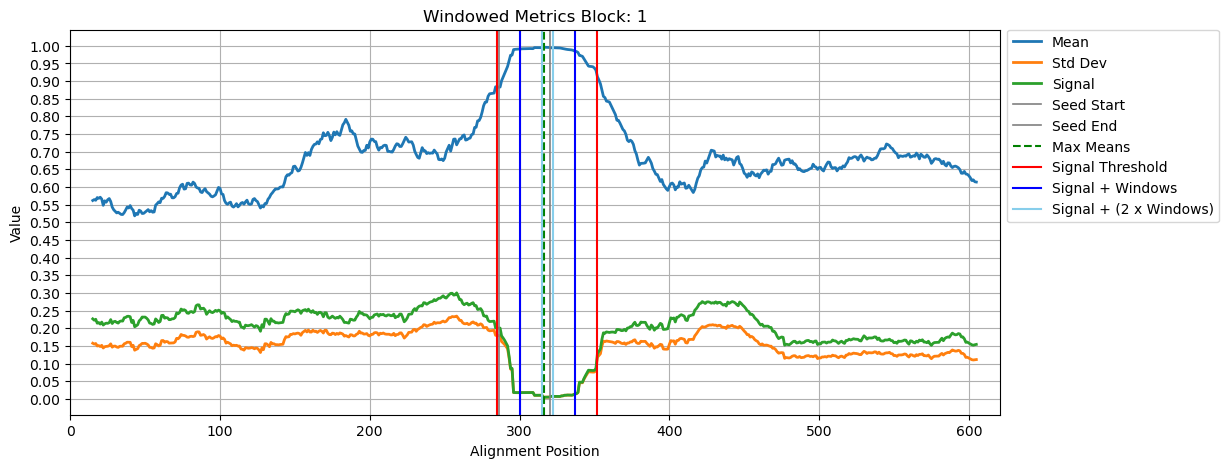

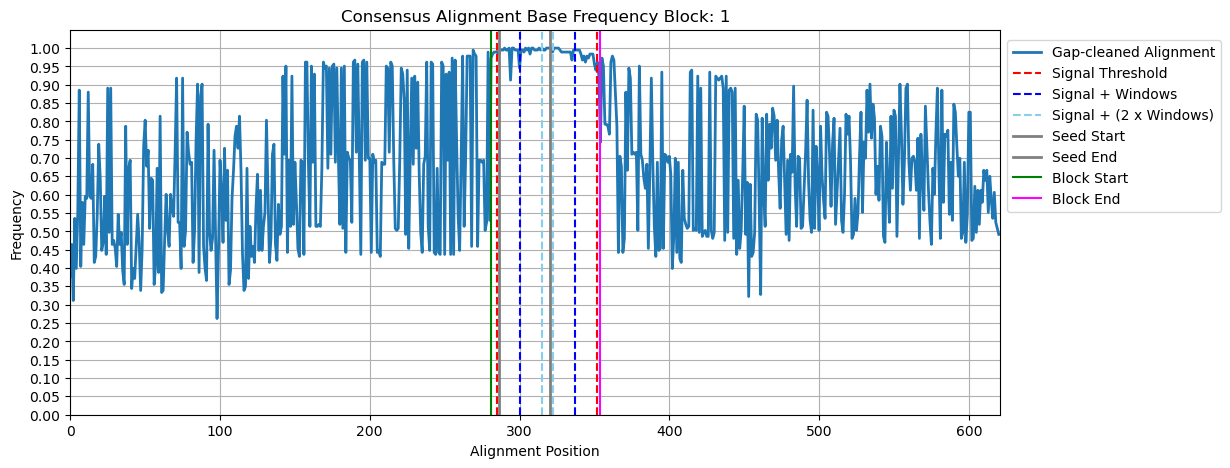

Working on target seed: k:7_c:169
Working on target seed: k:39_c:144
Working on target seed: k:0_c:172
Mapping seed: k:0_c:172

Processing Block Number: 2

Seed initial size: 34
Warning! Alignment extension (605) != expected (634). Attempting to locate seed in consensus.

Start signal Pos: 262
Mean Start signal Pos: 270
End signal Pos: 320
Mean End signal Pos: 312

Running: blastn -query /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/temp.seeds.fasta -subject /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/block-temp.fasta -out /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/temp.blast.seeds_fragment.tsv -reward 1 -gapextend 2 -gapopen 5 -penalty -2 -word_size 10 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn_subject ran successfully.


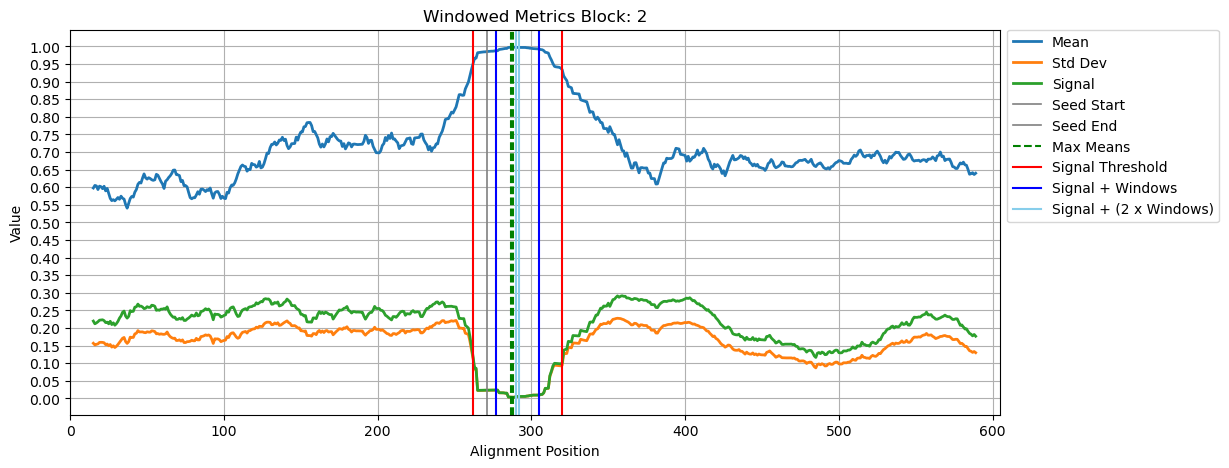

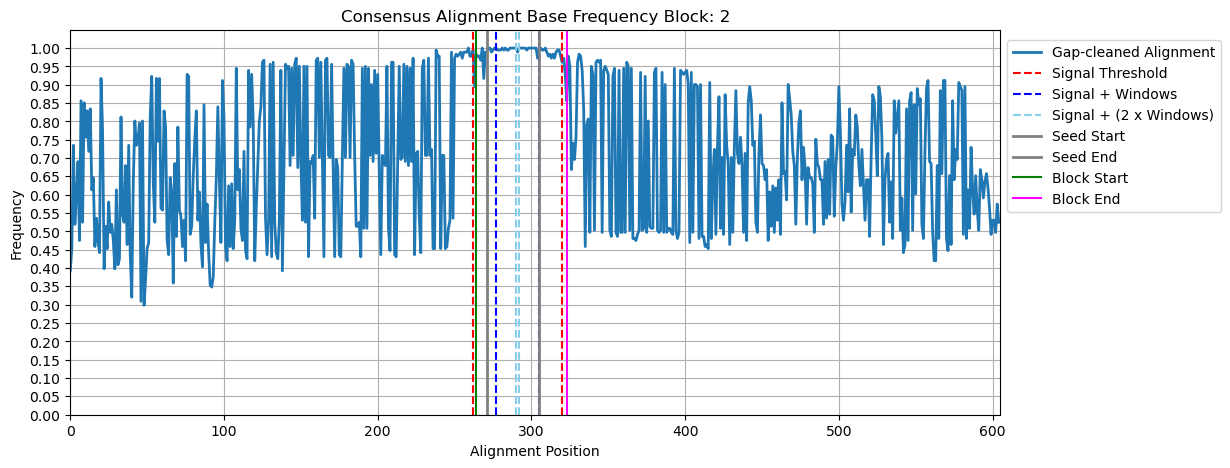

Working on target seed: k:38_c:144
Working on target seed: k:14_c:162
Working on target seed: k:1_c:171
Working on target seed: k:41_c:142
Working on target seed: k:40_c:143
Working on target seed: k:5_c:170
Working on target seed: k:4_c:171
Working on target seed: k:22_c:159
Working on target seed: k:8_c:166
Working on target seed: k:10_c:164
Working on target seed: k:6_c:170
Working on target seed: k:42_c:140
Working on target seed: k:13_c:162
Working on target seed: k:12_c:162
Working on target seed: k:3_c:171
Working on target seed: k:11_c:163
Working on target seed: k:15_c:162
Working on target seed: k:2_c:171
Working on target seed: k:153_c:79
Working on target seed: k:21_c:160
Working on target seed: k:495_c:60
Working on target seed: k:35_c:145
Working on target seed: k:9_c:165
Working on target seed: k:17_c:161
Working on target seed: k:23_c:158
Working on target seed: k:24_c:156
Working on target seed: k:19_c:160
Working on target seed: k:18_c:160
Working on target seed: k:16

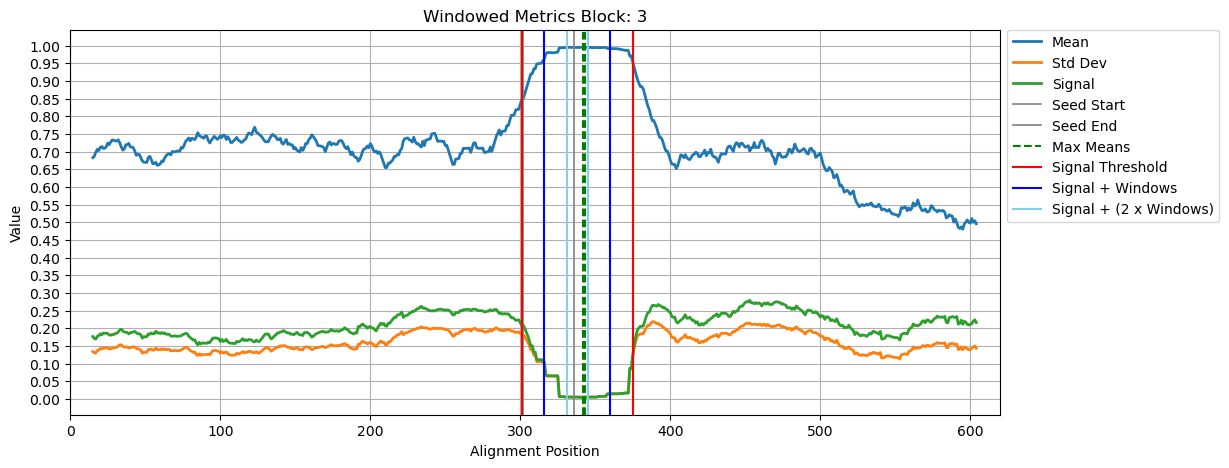

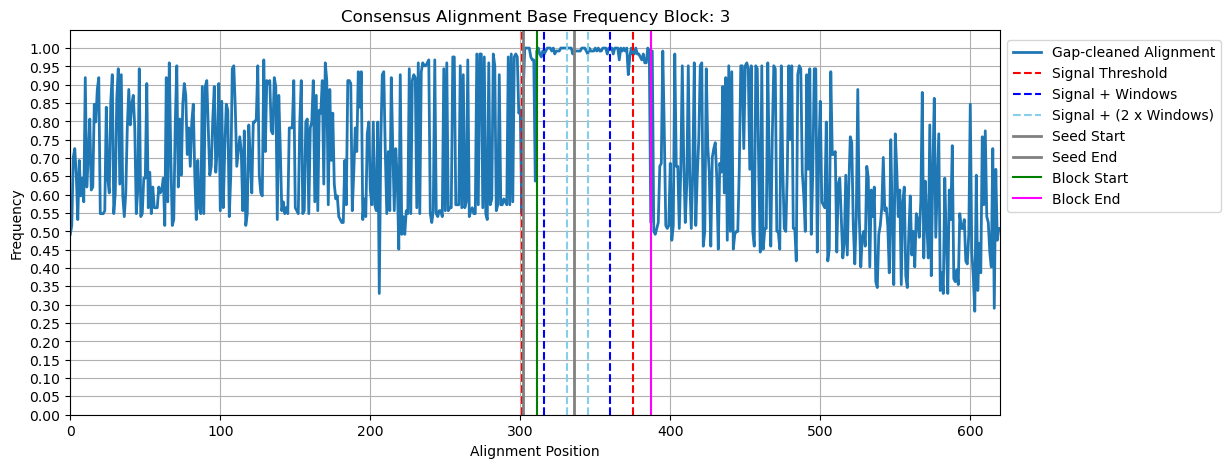

Working on target seed: k:1393_c:36
Mapping seed: k:1393_c:36

Processing Block Number: 4

Seed initial size: 34
Warning! Alignment extension (622) != expected (634). Attempting to locate seed in consensus.
No exact matches for seed in consensus. Skipping seed.
Working on target seed: k:85_c:86
Mapping seed: k:85_c:86

Processing Block Number: 5

Seed initial size: 34
Warning! Alignment extension (637) != expected (634). Attempting to locate seed in consensus.

Start signal Pos: 219
Mean Start signal Pos: 230
End signal Pos: 372
Mean End signal Pos: 367

Running: blastn -query /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/temp.seeds.fasta -subject /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/block-temp.fasta -out /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/temp.blast.seeds_fragment.tsv -reward 1 -gapextend 2 -gapopen 5 -penalty -2 -word_size 10 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue

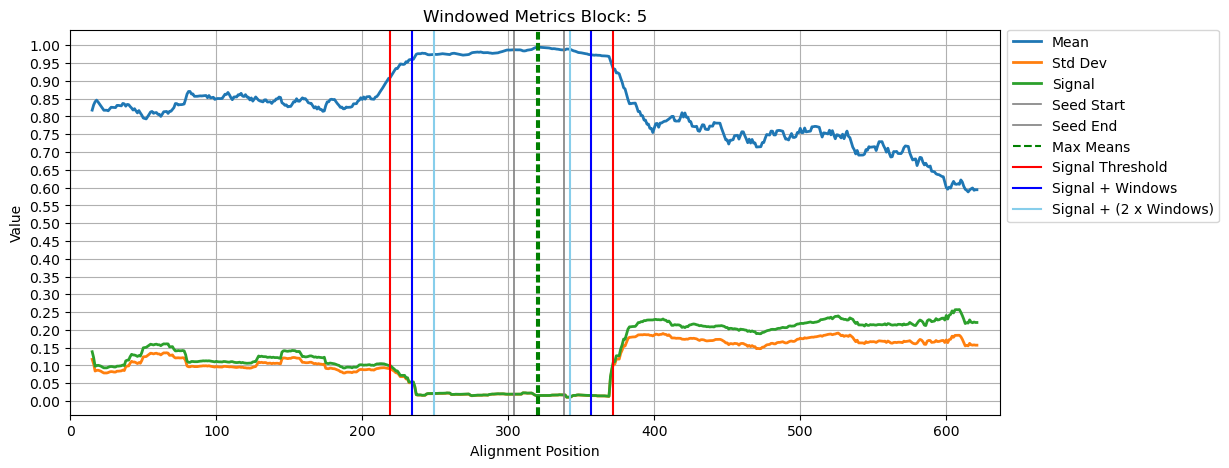

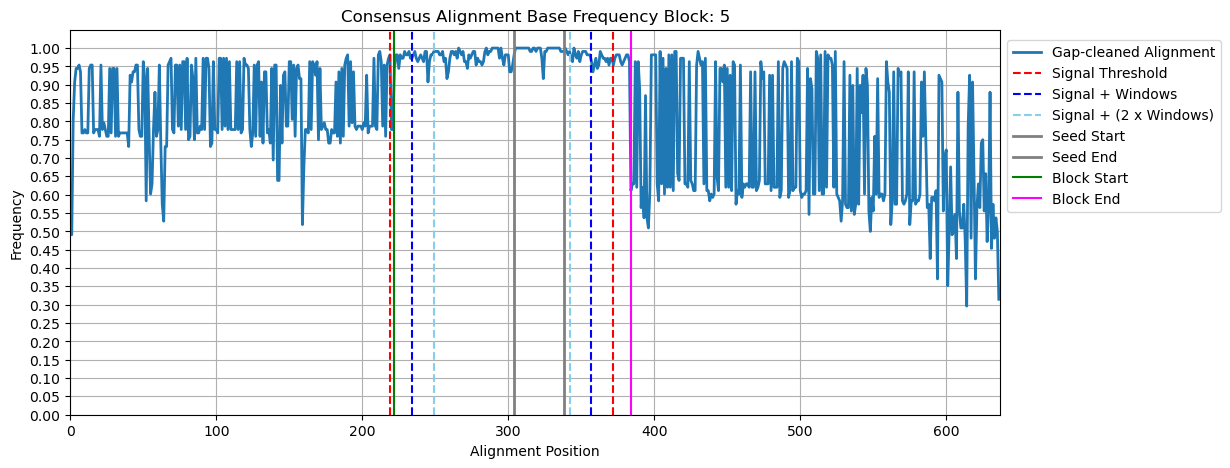

Working on target seed: k:73_c:88
Working on target seed: k:63_c:89
Working on target seed: k:101_c:84
Working on target seed: k:100_c:84
Working on target seed: k:60_c:89
Working on target seed: k:103_c:84
Working on target seed: k:43_c:93
Mapping seed: k:43_c:93

Processing Block Number: 6

Seed initial size: 34
Warning! Alignment extension (627) != expected (634). Attempting to locate seed in consensus.

Start signal Pos: 159
Mean Start signal Pos: 207
End signal Pos: 350
Mean End signal Pos: 345

Running: blastn -query /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/temp.seeds.fasta -subject /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/block-temp.fasta -out /home/jpereira/OEs/Results/OE1/toxoBrasil06/Data/seed_extension/temp.blast.seeds_fragment.tsv -reward 1 -gapextend 2 -gapopen 5 -penalty -2 -word_size 10 -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore qlen slen'
blastn_subject ran successfully.


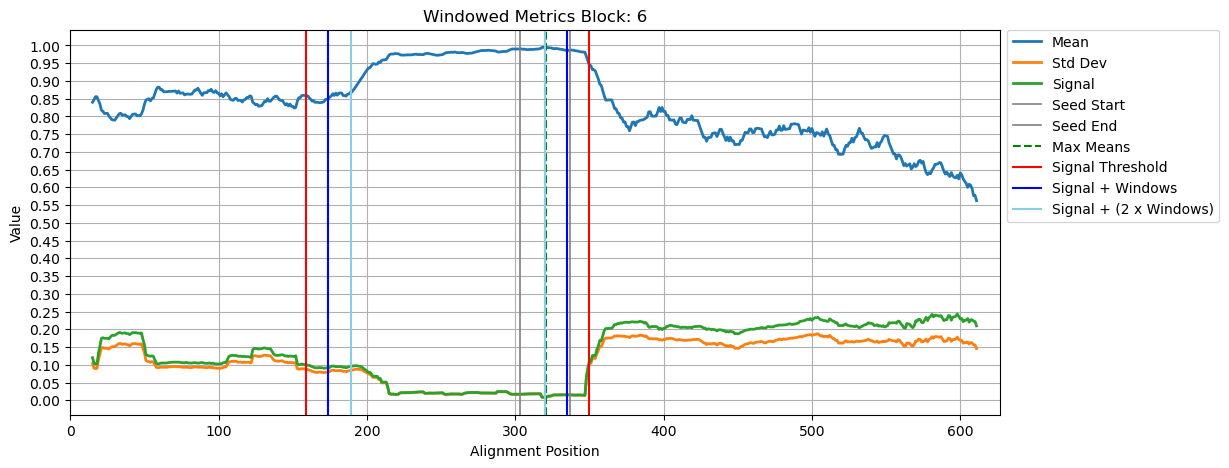

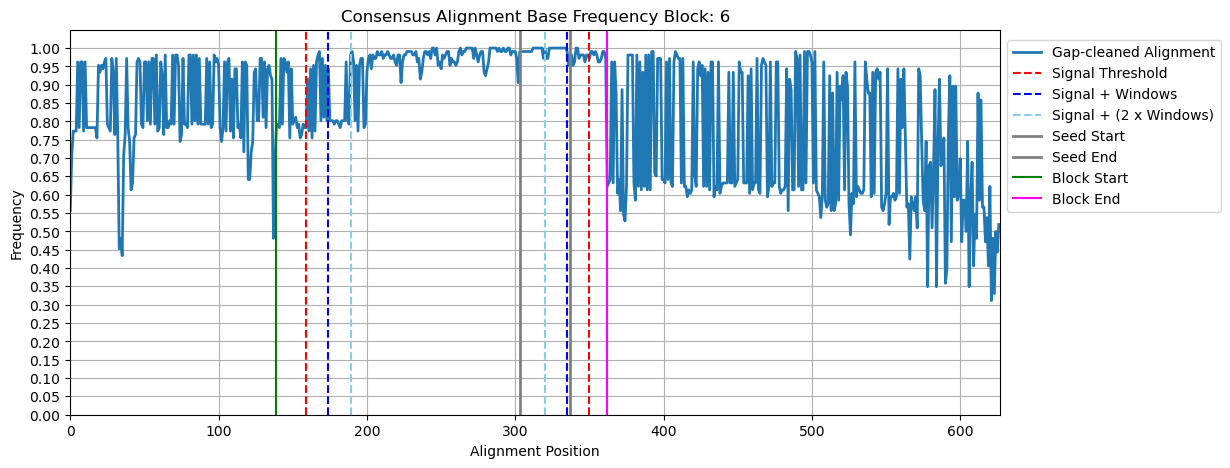

Working on target seed: k:121_c:82
Working on target seed: k:65_c:88
Working on target seed: k:58_c:90
Working on target seed: k:59_c:89
Working on target seed: k:128_c:82
Working on target seed: k:54_c:91
Working on target seed: k:117_c:83
Working on target seed: k:98_c:84
Working on target seed: k:84_c:86
Working on target seed: k:108_c:83
Working on target seed: k:52_c:92
Working on target seed: k:64_c:88
Working on target seed: k:53_c:92
Working on target seed: k:95_c:85
Working on target seed: k:109_c:83
Working on target seed: k:57_c:91
Working on target seed: k:78_c:87
Working on target seed: k:126_c:82
Working on target seed: k:91_c:86
Working on target seed: k:82_c:87
Working on target seed: k:76_c:87
Working on target seed: k:46_c:92
Working on target seed: k:94_c:85
Working on target seed: k:87_c:86
Working on target seed: k:50_c:92
Working on target seed: k:55_c:91
Working on target seed: k:146_c:80
Working on target seed: k:56_c:91
Working on target seed: k:207_c:75
Mappin

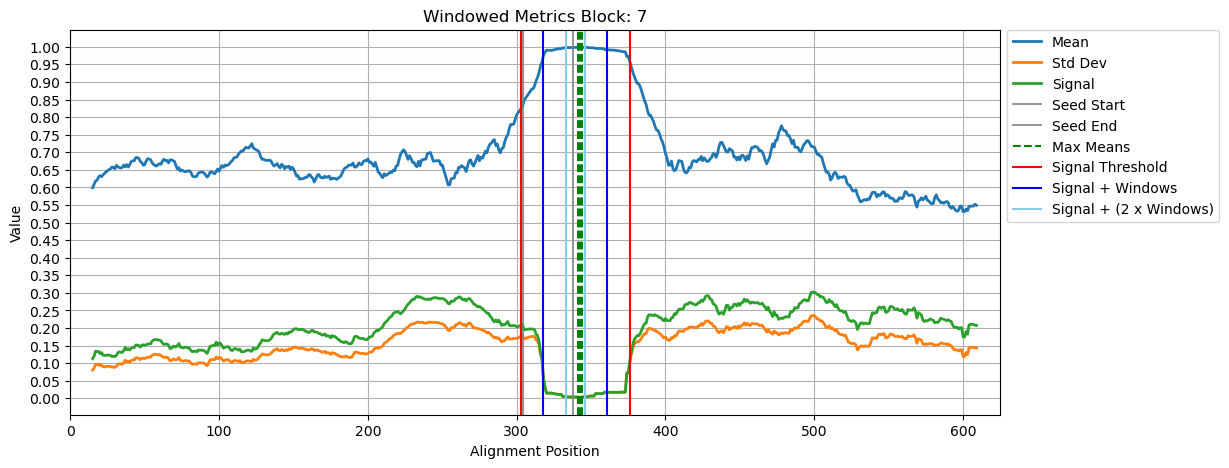

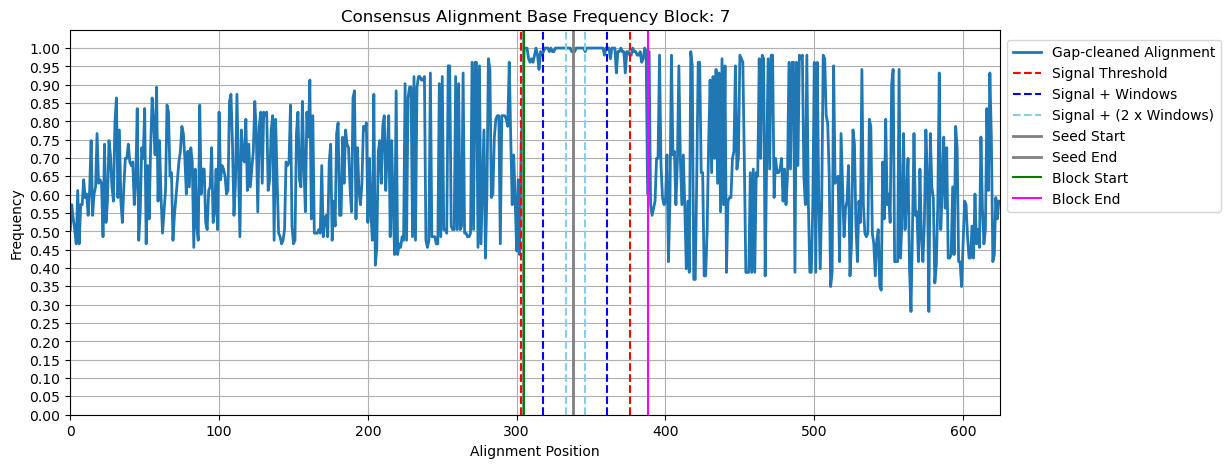

Working on target seed: k:111_c:83
Working on target seed: k:86_c:86
Working on target seed: k:47_c:92
Working on target seed: k:125_c:82
Working on target seed: k:61_c:89
Working on target seed: k:123_c:82
Working on target seed: k:127_c:82
Working on target seed: k:49_c:92
Working on target seed: k:163_c:78
Working on target seed: k:114_c:83
Working on target seed: k:105_c:83
Working on target seed: k:77_c:87
Working on target seed: k:48_c:92
Working on target seed: k:502_c:60
Working on target seed: k:118_c:83
Working on target seed: k:147_c:79
Working on target seed: k:122_c:82
Working on target seed: k:68_c:88
Working on target seed: k:62_c:89
Working on target seed: k:74_c:88
Working on target seed: k:113_c:83
Working on target seed: k:80_c:87
Working on target seed: k:45_c:92
Working on target seed: k:67_c:88
Working on target seed: k:164_c:78
Working on target seed: k:120_c:82
Working on target seed: k:132_c:81
Working on target seed: k:51_c:92
Working on target seed: k:124_c:8

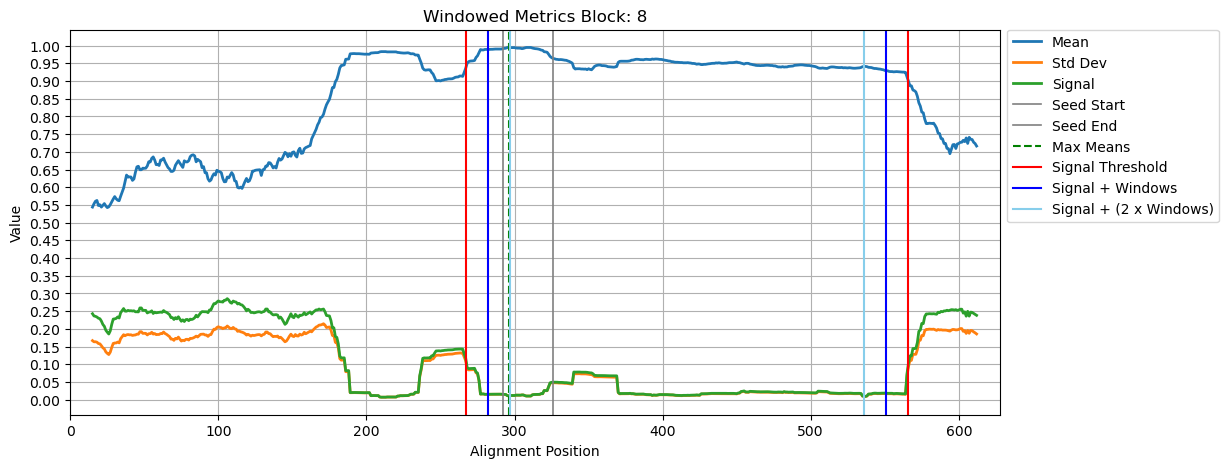

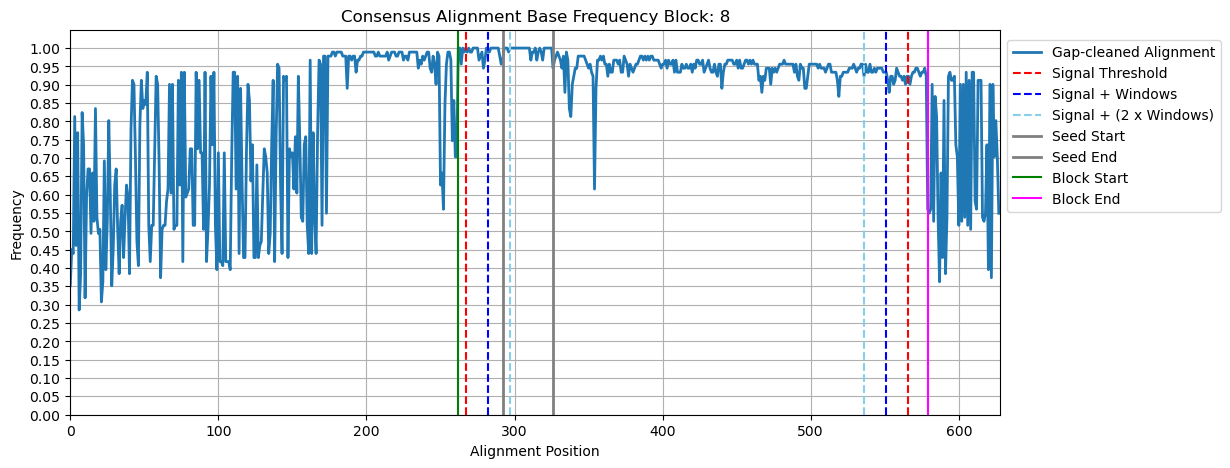

Working on target seed: k:199_c:76
Working on target seed: k:210_c:75
Working on target seed: k:141_c:80
Working on target seed: k:143_c:80
Working on target seed: k:144_c:80
Working on target seed: k:231_c:74
Working on target seed: k:165_c:78
Working on target seed: k:181_c:77
Working on target seed: k:196_c:76
Working on target seed: k:145_c:80
Working on target seed: k:217_c:75
Working on target seed: k:152_c:79
Working on target seed: k:174_c:77
Working on target seed: k:194_c:76
Working on target seed: k:170_c:77
Working on target seed: k:191_c:76
Working on target seed: k:186_c:76
Working on target seed: k:201_c:76
Working on target seed: k:198_c:76
Working on target seed: k:197_c:76
Working on target seed: k:225_c:74
Working on target seed: k:216_c:75
Working on target seed: k:202_c:76
Working on target seed: k:243_c:73
Working on target seed: k:178_c:77
Working on target seed: k:239_c:73
Working on target seed: k:279_c:71
Working on target seed: k:171_c:77
Working on target se

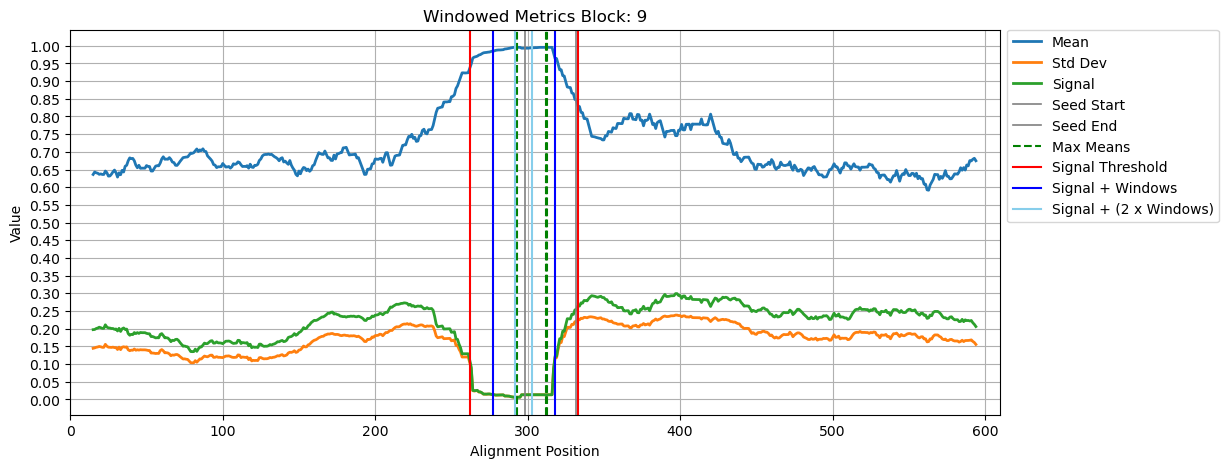

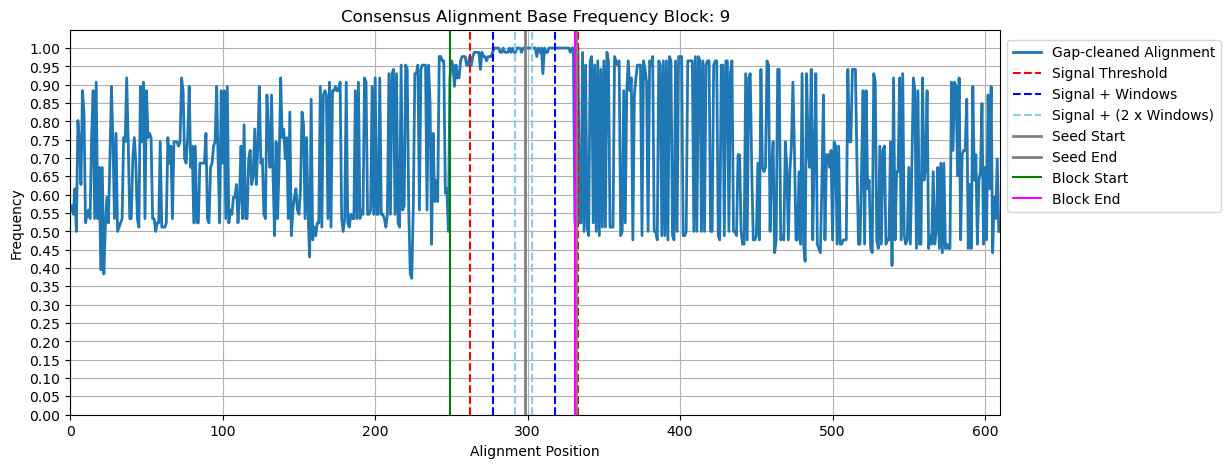

Working on target seed: k:240_c:73
Working on target seed: k:189_c:76
Working on target seed: k:180_c:77
Working on target seed: k:329_c:69
Working on target seed: k:247_c:73
Working on target seed: k:227_c:74
Working on target seed: k:149_c:79
Working on target seed: k:229_c:74
Working on target seed: k:167_c:78
Working on target seed: k:203_c:76
Working on target seed: k:187_c:76
Working on target seed: k:184_c:77
Working on target seed: k:320_c:69
Working on target seed: k:238_c:73
Working on target seed: k:288_c:71
Working on target seed: k:324_c:69
Working on target seed: k:949_c:44
Working on target seed: k:173_c:77
Working on target seed: k:251_c:72
Working on target seed: k:252_c:72
Working on target seed: k:159_c:78
Working on target seed: k:1458_c:35
Working on target seed: k:154_c:78
Working on target seed: k:328_c:69
Working on target seed: k:172_c:77
Working on target seed: k:185_c:77
Working on target seed: k:182_c:77
Working on target seed: k:241_c:73
Working on target s

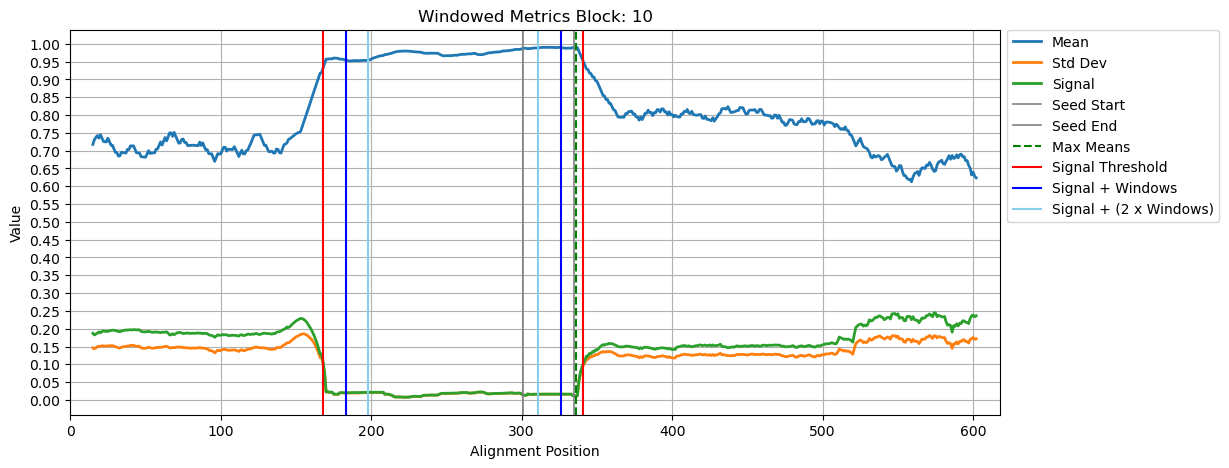

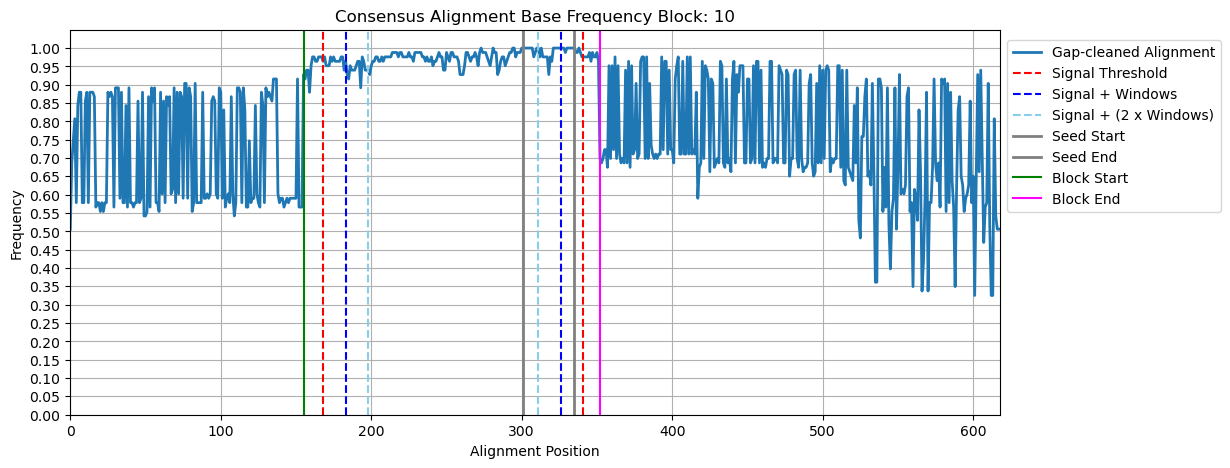

Working on target seed: k:407_c:64
Working on target seed: k:396_c:64
Working on target seed: k:397_c:64
Working on target seed: k:266_c:72
Working on target seed: k:302_c:70
Working on target seed: k:200_c:76
Working on target seed: k:305_c:70
Working on target seed: k:325_c:69
Working on target seed: k:221_c:74
Working on target seed: k:222_c:74
Working on target seed: k:223_c:74
Working on target seed: k:175_c:77
Working on target seed: k:299_c:71
Working on target seed: k:236_c:74
Working on target seed: k:226_c:74
Working on target seed: k:282_c:71
Working on target seed: k:307_c:70
Working on target seed: k:1026_c:42
Working on target seed: k:968_c:44
Working on target seed: k:255_c:72
Working on target seed: k:244_c:73
Working on target seed: k:316_c:70
Working on target seed: k:304_c:70
Working on target seed: k:272_c:71
Working on target seed: k:319_c:70
Working on target seed: k:420_c:63
Working on target seed: k:250_c:73
Working on target seed: k:326_c:69
Working on target s

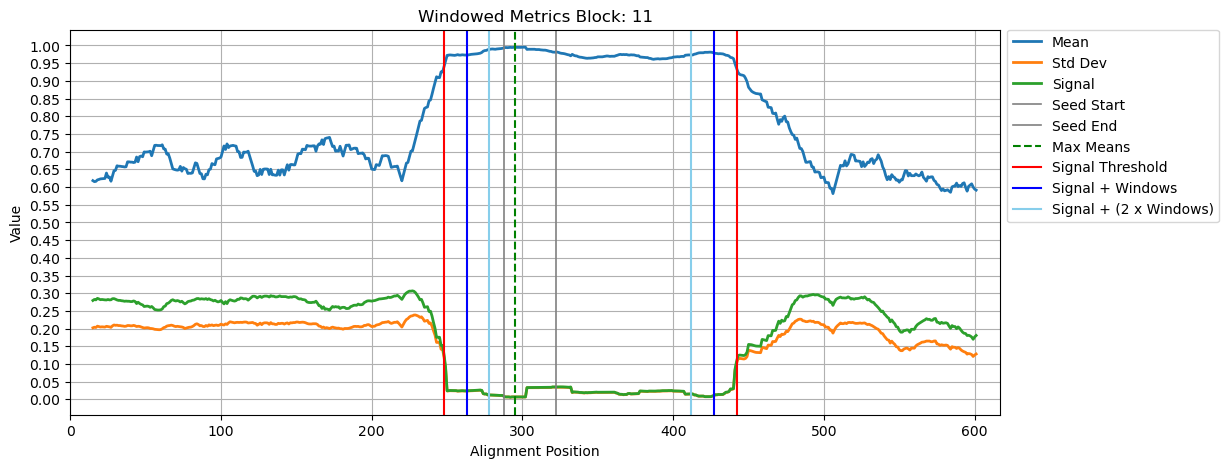

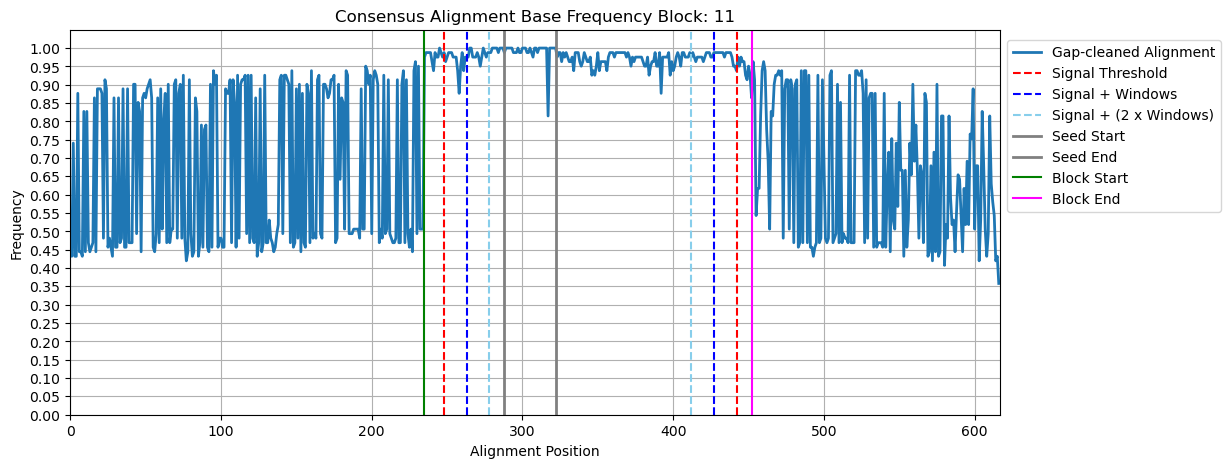

Working on target seed: k:264_c:72
Working on target seed: k:268_c:72
Working on target seed: k:276_c:71
Working on target seed: k:317_c:70
Working on target seed: k:208_c:75
Working on target seed: k:312_c:70
Working on target seed: k:213_c:75
Working on target seed: k:332_c:68
Working on target seed: k:267_c:72
Working on target seed: k:262_c:72
Working on target seed: k:269_c:72
Working on target seed: k:232_c:74
Working on target seed: k:242_c:73
Working on target seed: k:246_c:73
Working on target seed: k:666_c:55
Working on target seed: k:206_c:75
Working on target seed: k:445_c:62
Working on target seed: k:486_c:61
Working on target seed: k:235_c:74
Working on target seed: k:313_c:70
Working on target seed: k:228_c:74
Working on target seed: k:1368_c:37
Working on target seed: k:424_c:63
Working on target seed: k:428_c:63
Working on target seed: k:293_c:71
Working on target seed: k:257_c:72
Working on target seed: k:212_c:75
Mapping seed: k:212_c:75

Processing Block Number: 12


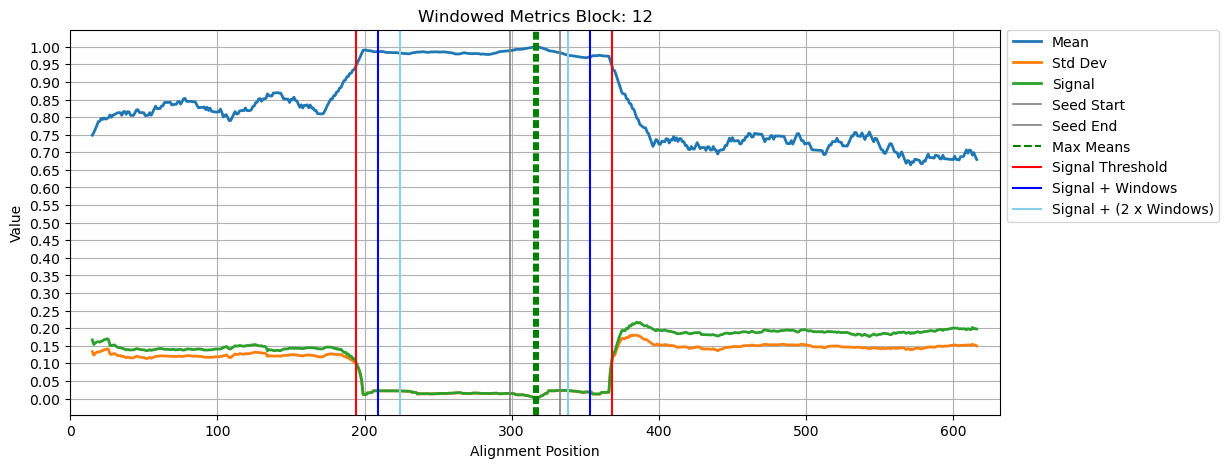

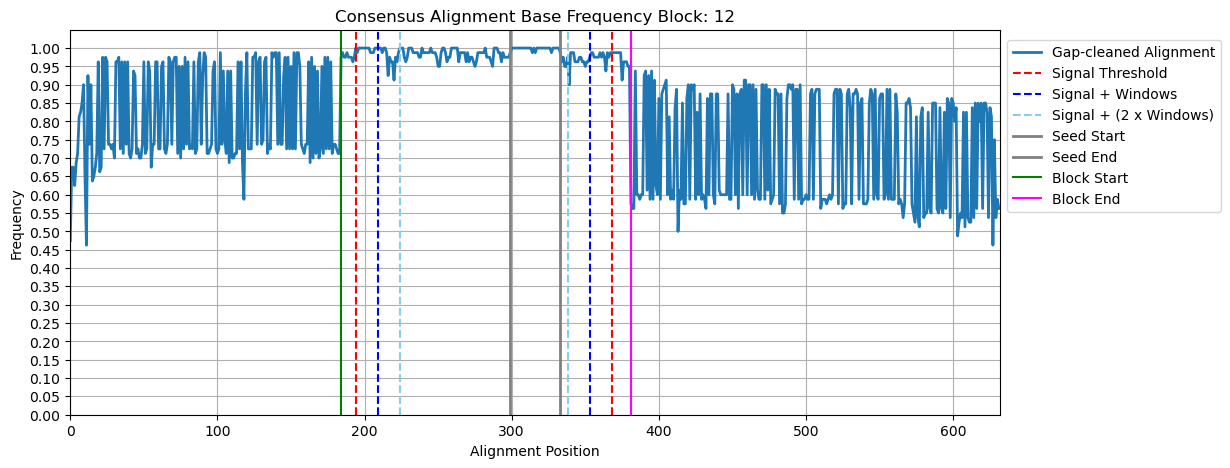

Working on target seed: k:323_c:69
Working on target seed: k:214_c:75
Working on target seed: k:333_c:68
Working on target seed: k:531_c:59
Working on target seed: k:408_c:64
Working on target seed: k:249_c:73
Working on target seed: k:237_c:74
Working on target seed: k:426_c:63
Working on target seed: k:218_c:75
Working on target seed: k:308_c:70
Working on target seed: k:295_c:71
Working on target seed: k:230_c:74
Working on target seed: k:371_c:66
Working on target seed: k:507_c:60
Working on target seed: k:224_c:74
Working on target seed: k:219_c:75
Working on target seed: k:273_c:71
Working on target seed: k:592_c:57
Working on target seed: k:292_c:71
Working on target seed: k:281_c:71
Working on target seed: k:443_c:62
Working on target seed: k:311_c:70
Working on target seed: k:310_c:70
Working on target seed: k:220_c:74
Working on target seed: k:245_c:73
Working on target seed: k:283_c:71
Working on target seed: k:290_c:71
Working on target seed: k:315_c:70
Working on target se

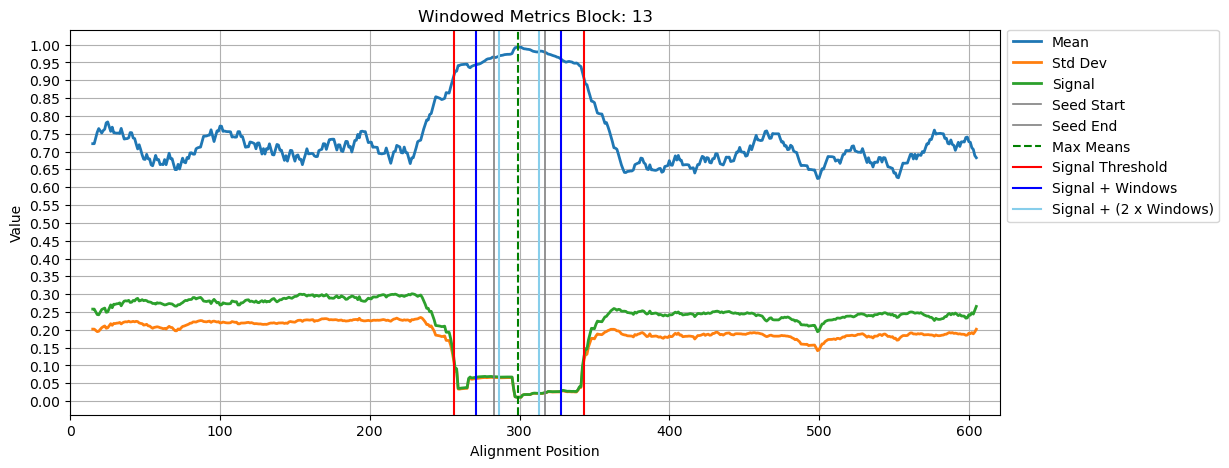

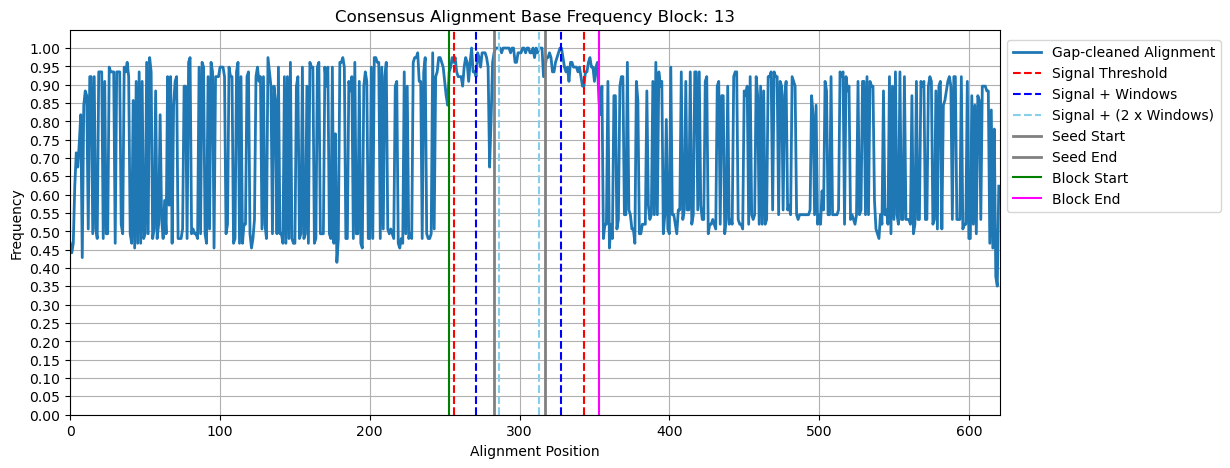

Working on target seed: k:441_c:62
Working on target seed: k:297_c:71
Working on target seed: k:431_c:63
Working on target seed: k:405_c:64
Working on target seed: k:489_c:61
Working on target seed: k:492_c:61
Working on target seed: k:423_c:63
Working on target seed: k:422_c:63
Working on target seed: k:429_c:63
Working on target seed: k:1138_c:40
Working on target seed: k:277_c:71
Working on target seed: k:689_c:54
Working on target seed: k:291_c:71
Working on target seed: k:294_c:71
Working on target seed: k:286_c:71
Working on target seed: k:278_c:71
Working on target seed: k:373_c:65
Working on target seed: k:275_c:71
Working on target seed: k:435_c:63
Working on target seed: k:359_c:66
Working on target seed: k:571_c:57
Working on target seed: k:375_c:65
Working on target seed: k:410_c:64
Working on target seed: k:280_c:71
Working on target seed: k:274_c:71
Working on target seed: k:399_c:64
Working on target seed: k:789_c:50
Working on target seed: k:361_c:66
Working on target s

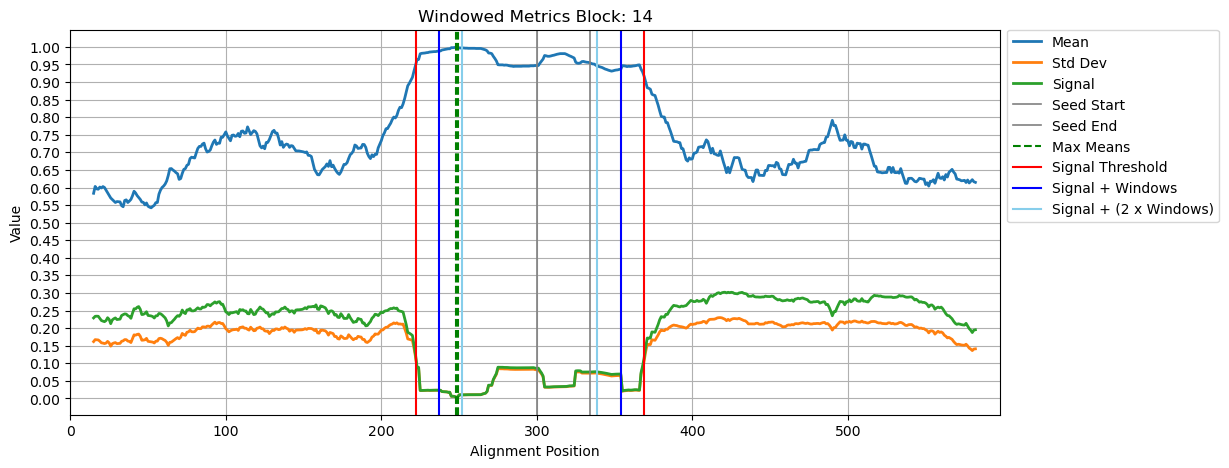

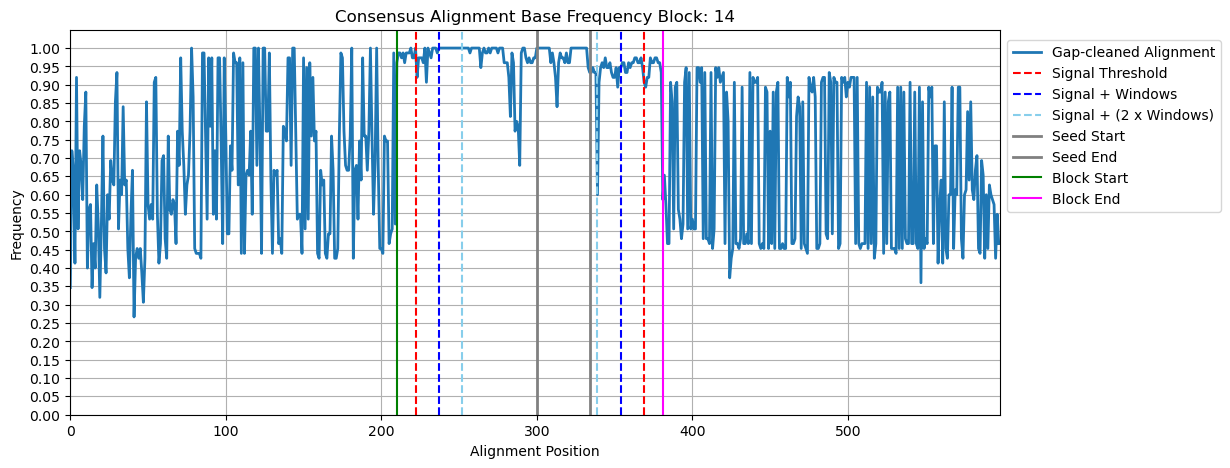

Working on target seed: k:389_c:65
Working on target seed: k:400_c:64
Working on target seed: k:409_c:64
Working on target seed: k:480_c:61
Working on target seed: k:952_c:44
Working on target seed: k:1006_c:43
Working on target seed: k:1002_c:43
Working on target seed: k:596_c:57
Working on target seed: k:590_c:57
Working on target seed: k:696_c:54
Working on target seed: k:589_c:57
Working on target seed: k:544_c:58
Working on target seed: k:526_c:59
Working on target seed: k:487_c:61
Working on target seed: k:513_c:59
Working on target seed: k:462_c:62
Working on target seed: k:463_c:62
Working on target seed: k:391_c:64
Working on target seed: k:442_c:62
Working on target seed: k:367_c:66
Working on target seed: k:356_c:67
Working on target seed: k:862_c:47
Working on target seed: k:871_c:46
Working on target seed: k:369_c:66
Working on target seed: k:370_c:66
Working on target seed: k:379_c:65
Working on target seed: k:402_c:64
Working on target seed: k:351_c:67
Working on target 

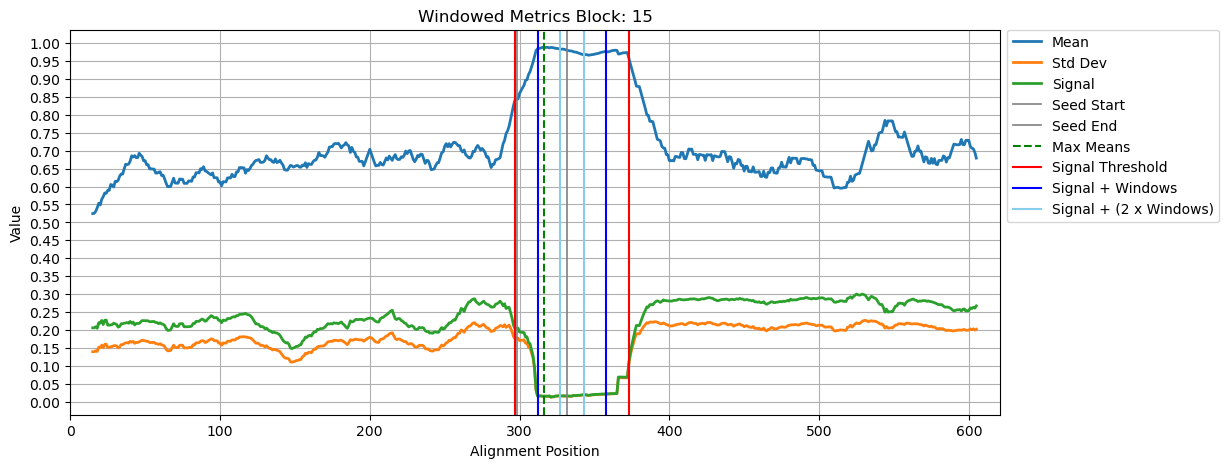

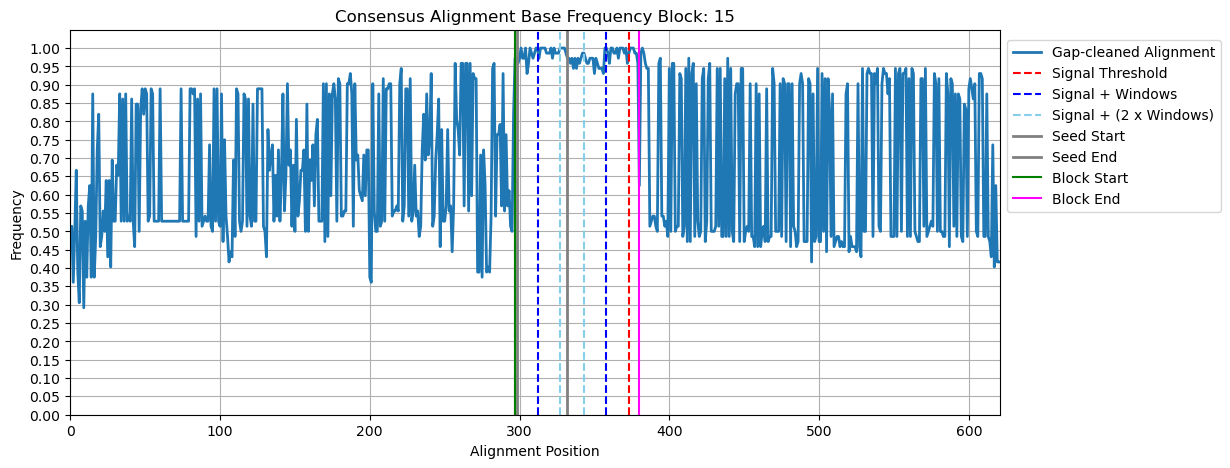

Working on target seed: k:481_c:61
Working on target seed: k:468_c:61
Working on target seed: k:368_c:66
Working on target seed: k:354_c:67
Working on target seed: k:703_c:54
Working on target seed: k:716_c:53
Working on target seed: k:575_c:57
Working on target seed: k:602_c:57
Working on target seed: k:568_c:57
Working on target seed: k:574_c:57
Working on target seed: k:600_c:57
Working on target seed: k:416_c:63
Working on target seed: k:377_c:65
Working on target seed: k:934_c:44
Working on target seed: k:569_c:57
Working on target seed: k:439_c:62
Working on target seed: k:648_c:55
Working on target seed: k:588_c:57
Working on target seed: k:599_c:57
Working on target seed: k:585_c:57
Working on target seed: k:479_c:61
Working on target seed: k:451_c:62
Working on target seed: k:404_c:64
Working on target seed: k:382_c:65
Working on target seed: k:415_c:64
Working on target seed: k:364_c:66
Working on target seed: k:344_c:67
Working on target seed: k:924_c:45
Working on target se

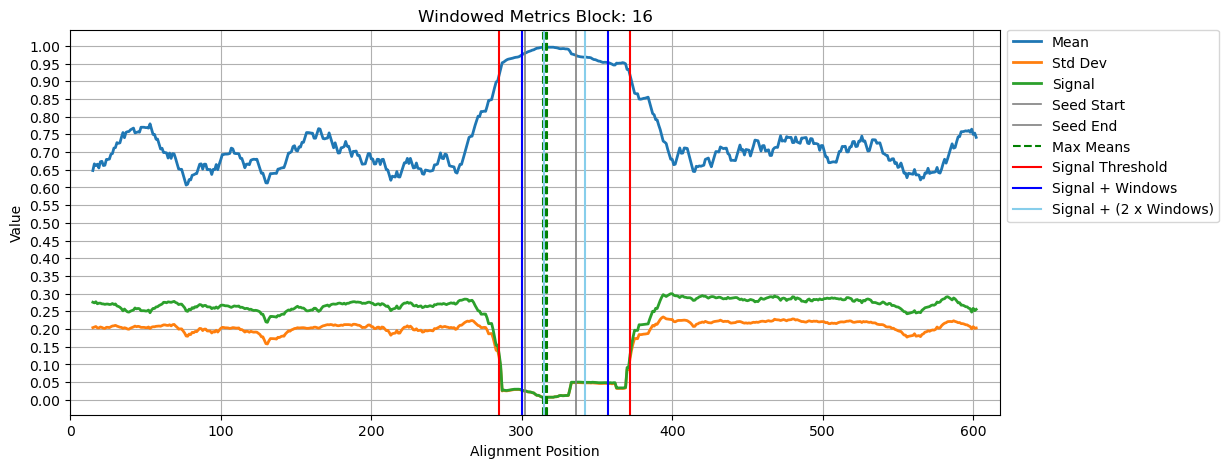

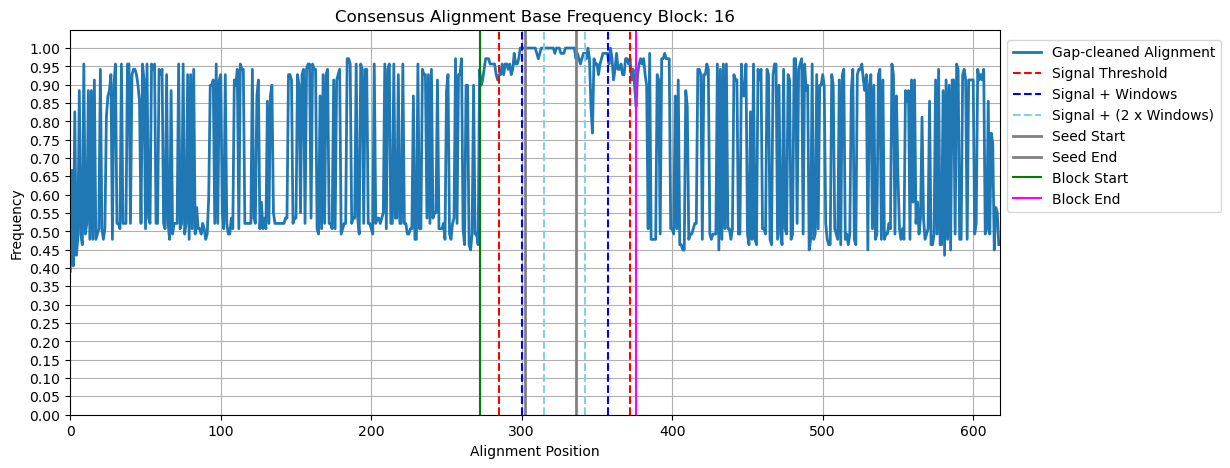

Working on target seed: k:437_c:63
Working on target seed: k:671_c:55
Working on target seed: k:465_c:61
Working on target seed: k:427_c:63
Working on target seed: k:483_c:61
Working on target seed: k:474_c:61
Working on target seed: k:449_c:62
Working on target seed: k:464_c:61
Working on target seed: k:681_c:55
Working on target seed: k:511_c:59
Working on target seed: k:1370_c:37
Working on target seed: k:493_c:61
Working on target seed: k:517_c:59
Working on target seed: k:555_c:58
Working on target seed: k:542_c:58
Working on target seed: k:546_c:58
Working on target seed: k:529_c:59
Working on target seed: k:791_c:50
Working on target seed: k:387_c:65
Working on target seed: k:386_c:65
Working on target seed: k:406_c:64
Working on target seed: k:525_c:59
Working on target seed: k:519_c:59
Working on target seed: k:551_c:58
Working on target seed: k:494_c:61
Working on target seed: k:673_c:55
Working on target seed: k:1134_c:40
Working on target seed: k:540_c:58
Working on target 

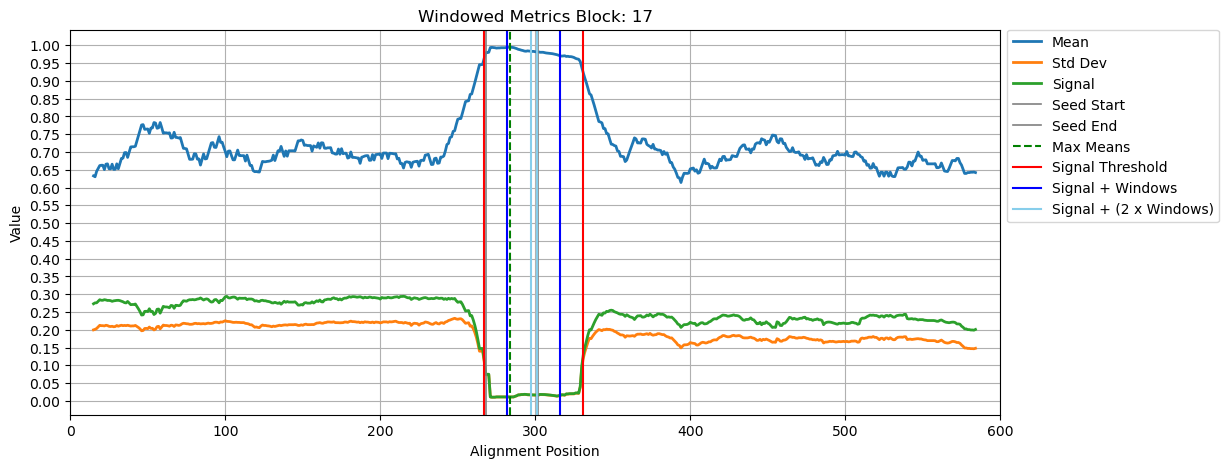

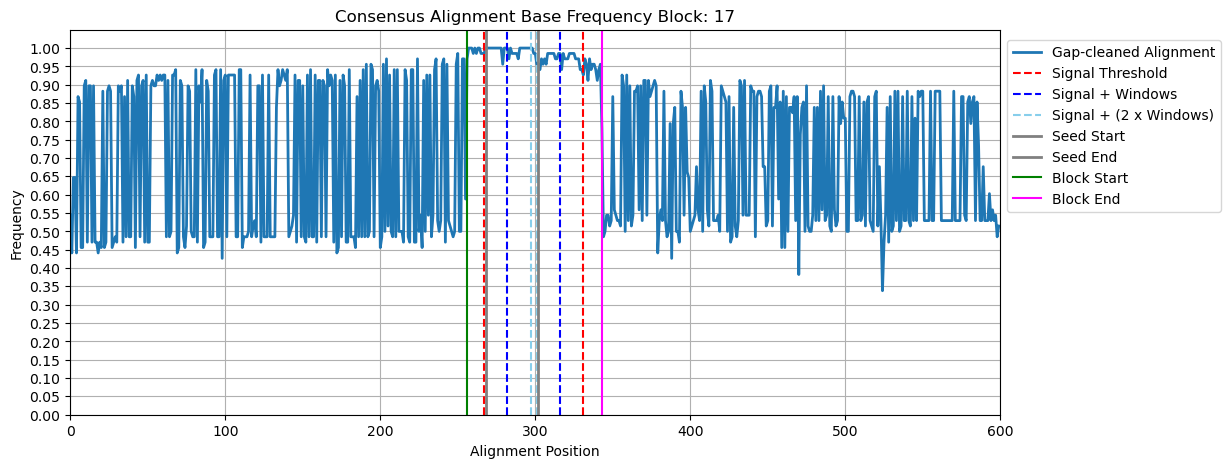

Working on target seed: k:664_c:55
Working on target seed: k:601_c:57
Working on target seed: k:595_c:57
Working on target seed: k:1027_c:42
Working on target seed: k:894_c:45
Working on target seed: k:625_c:56
Working on target seed: k:977_c:43
Working on target seed: k:658_c:55
Working on target seed: k:635_c:56
Working on target seed: k:657_c:55
Working on target seed: k:1149_c:40
Working on target seed: k:621_c:56
Working on target seed: k:651_c:55
Working on target seed: k:565_c:57
Working on target seed: k:581_c:57
Working on target seed: k:485_c:61
Working on target seed: k:702_c:54
Working on target seed: k:1155_c:40
Working on target seed: k:452_c:62
Working on target seed: k:705_c:54
Working on target seed: k:523_c:59
Working on target seed: k:663_c:55
Working on target seed: k:719_c:53
Working on target seed: k:996_c:43
Mapping seed: k:996_c:43

Processing Block Number: 18

Seed initial size: 34
Warning! Alignment extension (635) != expected (634). Attempting to locate seed 

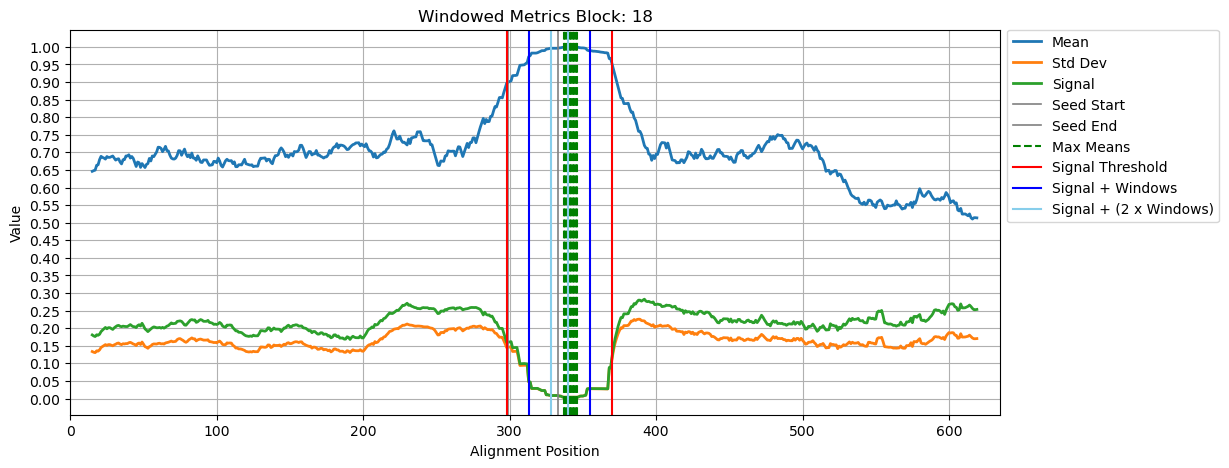

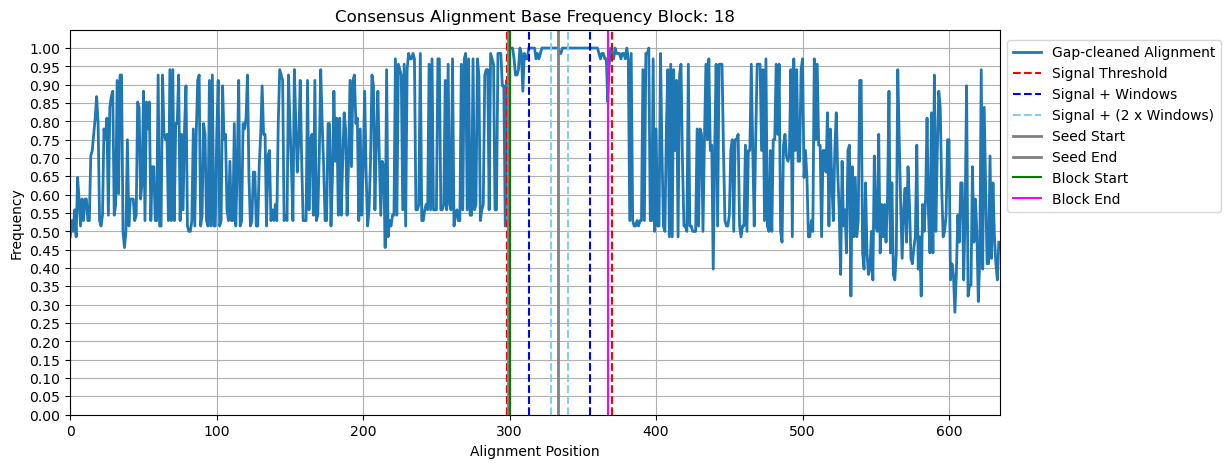

Working on target seed: k:1224_c:39
Working on target seed: k:461_c:62
Working on target seed: k:457_c:62
Working on target seed: k:725_c:53
Working on target seed: k:740_c:52
Working on target seed: k:792_c:50
Working on target seed: k:460_c:62
Working on target seed: k:477_c:61
Working on target seed: k:690_c:54
Working on target seed: k:381_c:65
Working on target seed: k:985_c:43
Working on target seed: k:731_c:53
Working on target seed: k:1011_c:42
Working on target seed: k:987_c:43
Working on target seed: k:473_c:61
Working on target seed: k:440_c:62
Working on target seed: k:505_c:60
Working on target seed: k:552_c:58
Working on target seed: k:1151_c:40
Working on target seed: k:506_c:60
Working on target seed: k:548_c:58
Working on target seed: k:1130_c:40
Working on target seed: k:549_c:58
Working on target seed: k:668_c:55
Working on target seed: k:532_c:59
Working on target seed: k:491_c:61
Working on target seed: k:675_c:55
Working on target seed: k:674_c:55
Working on targe

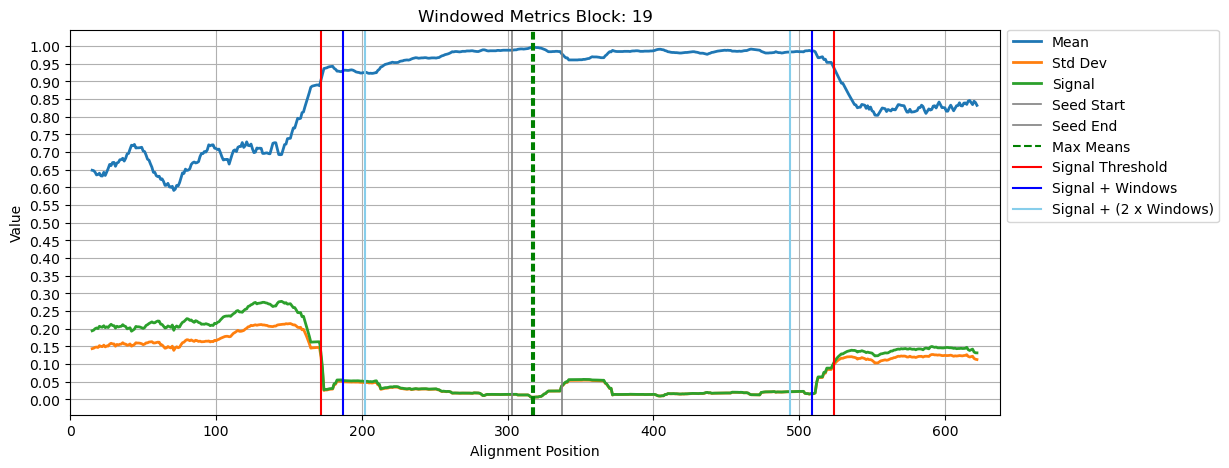

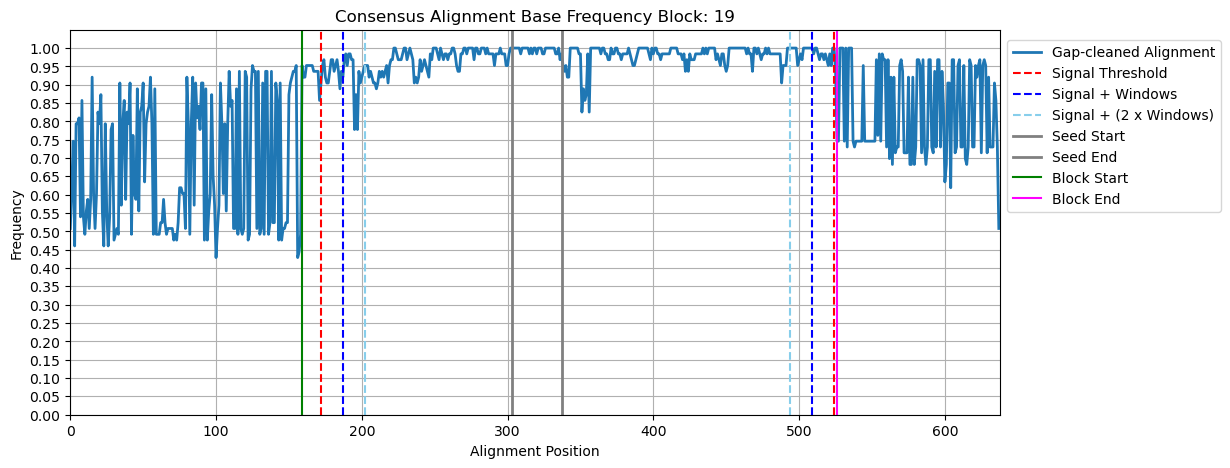

Working on target seed: k:770_c:51
Working on target seed: k:762_c:51
Working on target seed: k:1278_c:38
Working on target seed: k:822_c:49
Working on target seed: k:634_c:56
Working on target seed: k:953_c:44
Working on target seed: k:583_c:57
Working on target seed: k:557_c:58
Working on target seed: k:1354_c:37
Working on target seed: k:830_c:49
Working on target seed: k:576_c:57
Working on target seed: k:547_c:58
Working on target seed: k:516_c:59
Working on target seed: k:550_c:58
Working on target seed: k:1449_c:35
Working on target seed: k:637_c:56
Working on target seed: k:1491_c:35
Working on target seed: k:642_c:56
Working on target seed: k:609_c:56
Working on target seed: k:627_c:56
Working on target seed: k:632_c:56
Working on target seed: k:1356_c:37
Working on target seed: k:847_c:47
Working on target seed: k:832_c:49
Working on target seed: k:536_c:58
Working on target seed: k:535_c:58
Working on target seed: k:541_c:58
Working on target seed: k:768_c:51
Working on targ

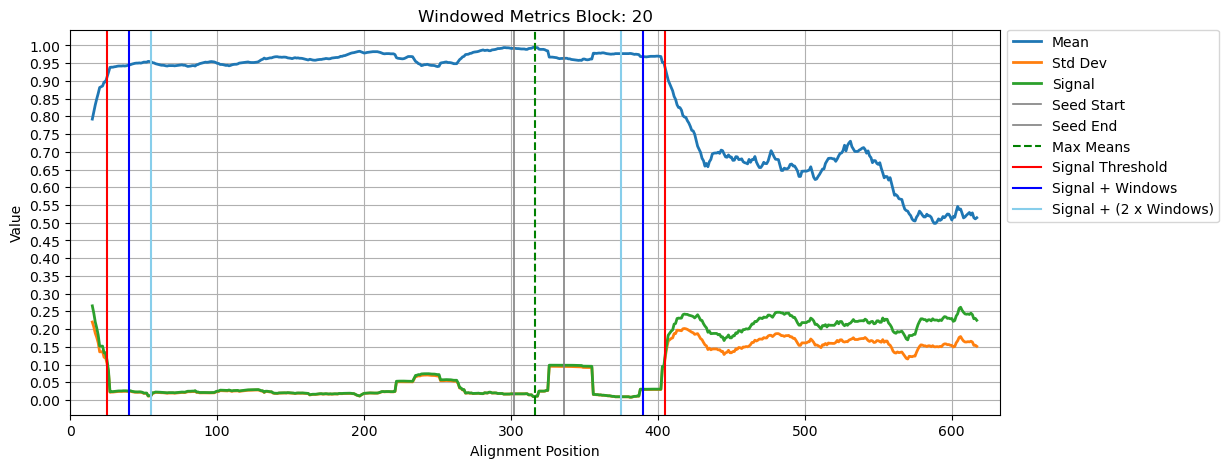

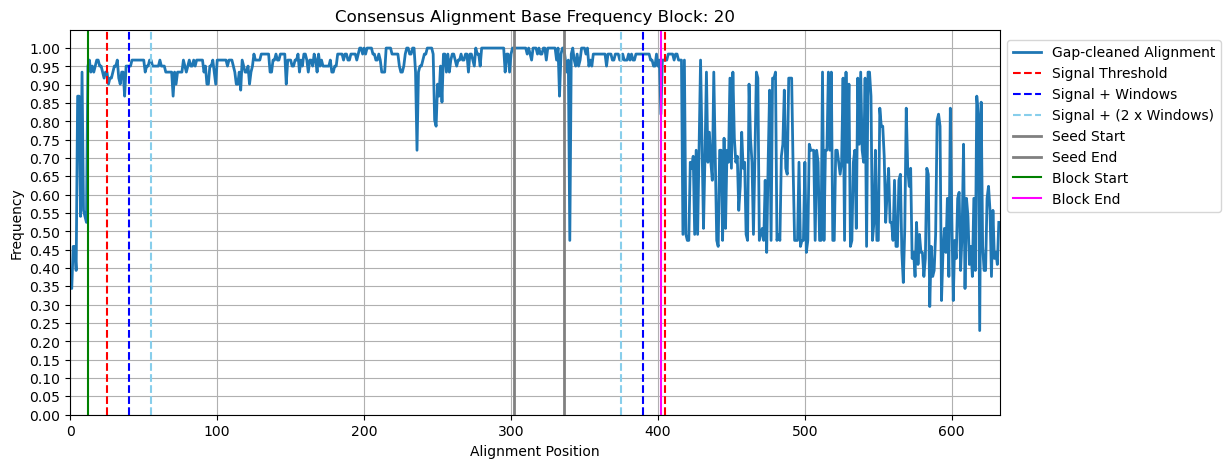

Working on target seed: k:796_c:50
Working on target seed: k:572_c:57
Working on target seed: k:534_c:58
Working on target seed: k:763_c:51
Working on target seed: k:745_c:52
Working on target seed: k:767_c:51
Working on target seed: k:879_c:46
Working on target seed: k:670_c:55
Working on target seed: k:626_c:56
Working on target seed: k:597_c:57
Working on target seed: k:1294_c:38
Working on target seed: k:615_c:56
Working on target seed: k:612_c:56
Working on target seed: k:562_c:58
Working on target seed: k:865_c:47
Working on target seed: k:580_c:57
Working on target seed: k:563_c:57
Working on target seed: k:653_c:55
Working on target seed: k:614_c:56
Working on target seed: k:695_c:54
Working on target seed: k:709_c:54
Working on target seed: k:1226_c:39
Working on target seed: k:735_c:53
Working on target seed: k:573_c:57
Working on target seed: k:617_c:56
Working on target seed: k:639_c:56
Working on target seed: k:641_c:56
Working on target seed: k:687_c:54
Working on target 

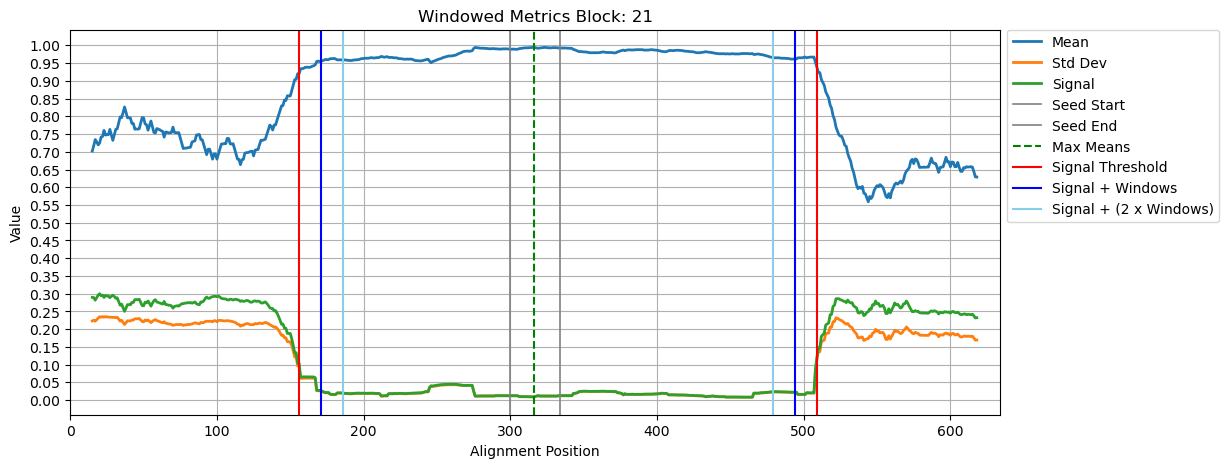

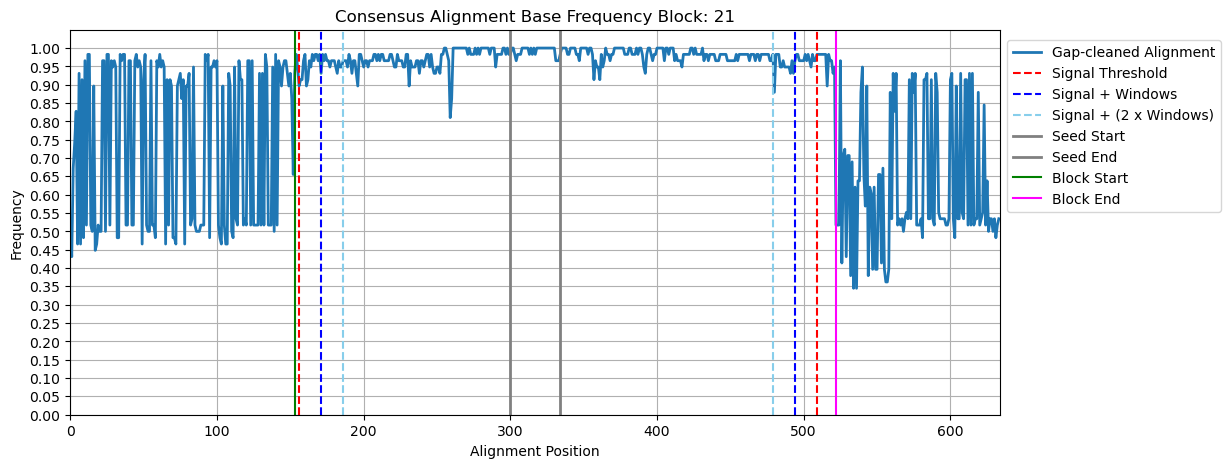

Working on target seed: k:672_c:55
Working on target seed: k:858_c:47
Working on target seed: k:667_c:55
Working on target seed: k:1104_c:40
Working on target seed: k:882_c:46
Working on target seed: k:849_c:47
Working on target seed: k:743_c:52
Working on target seed: k:970_c:44
Working on target seed: k:798_c:50
Working on target seed: k:741_c:52
Working on target seed: k:726_c:53
Working on target seed: k:729_c:53
Working on target seed: k:733_c:53
Working on target seed: k:736_c:53
Working on target seed: k:739_c:52
Working on target seed: k:812_c:49
Working on target seed: k:904_c:45
Working on target seed: k:794_c:50
Working on target seed: k:764_c:51
Working on target seed: k:717_c:53
Working on target seed: k:715_c:53
Working on target seed: k:755_c:51
Working on target seed: k:718_c:53
Working on target seed: k:771_c:50
Working on target seed: k:773_c:50
Working on target seed: k:781_c:50
Working on target seed: k:872_c:46
Working on target seed: k:776_c:50
Working on target s

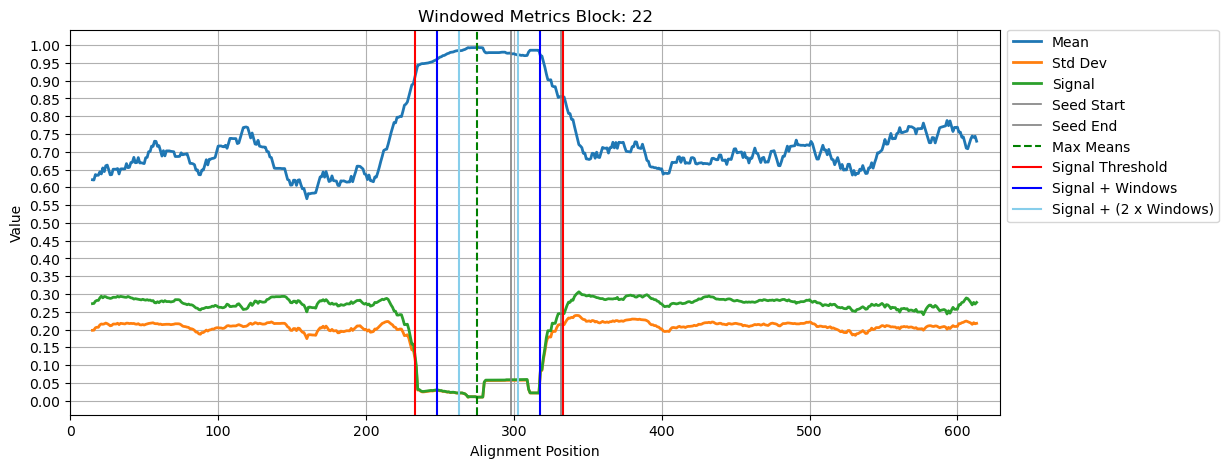

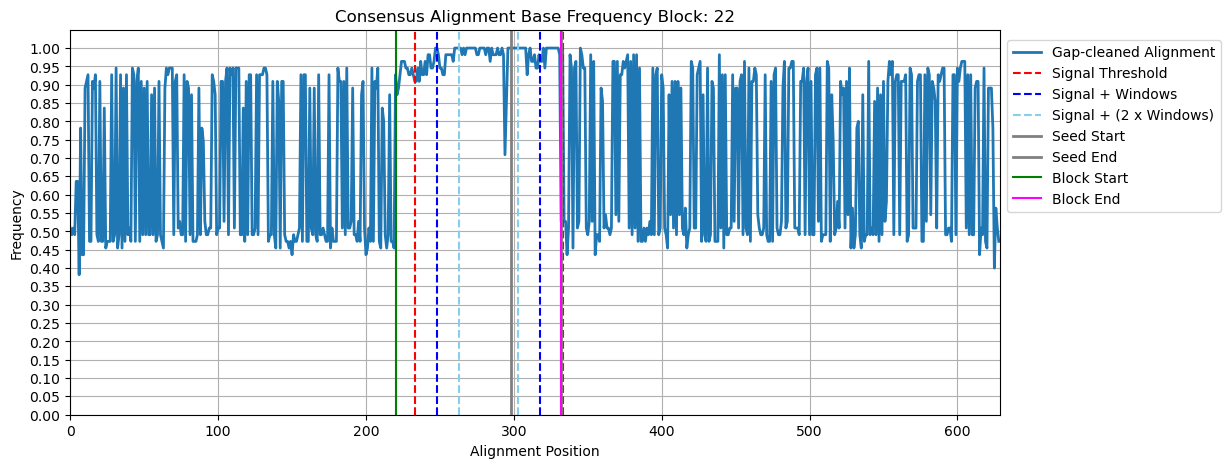

Working on target seed: k:811_c:49
Working on target seed: k:810_c:49
Working on target seed: k:799_c:50
Working on target seed: k:829_c:49
Working on target seed: k:903_c:45
Working on target seed: k:975_c:43
Working on target seed: k:912_c:45
Working on target seed: k:855_c:47
Working on target seed: k:845_c:48
Working on target seed: k:1139_c:40
Working on target seed: k:983_c:43
Working on target seed: k:848_c:47
Working on target seed: k:1083_c:41
Working on target seed: k:828_c:49
Working on target seed: k:1159_c:40
Working on target seed: k:836_c:48
Working on target seed: k:1398_c:36
Working on target seed: k:803_c:49
Working on target seed: k:807_c:49
Working on target seed: k:1154_c:40
Working on target seed: k:1298_c:38
Working on target seed: k:945_c:44
Working on target seed: k:1247_c:38
Working on target seed: k:790_c:50
Working on target seed: k:825_c:49
Working on target seed: k:837_c:48
Working on target seed: k:823_c:49
Working on target seed: k:954_c:44
Working on ta

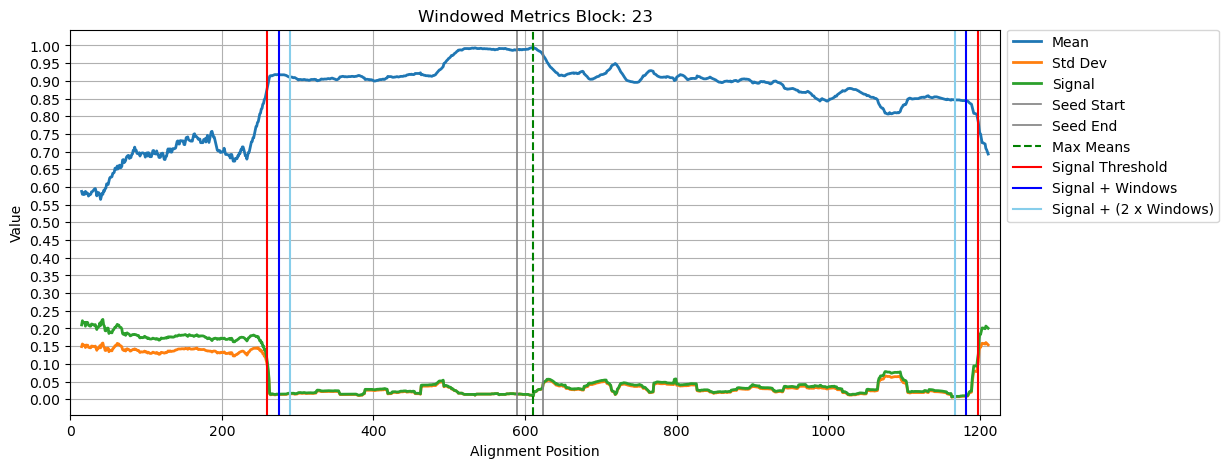

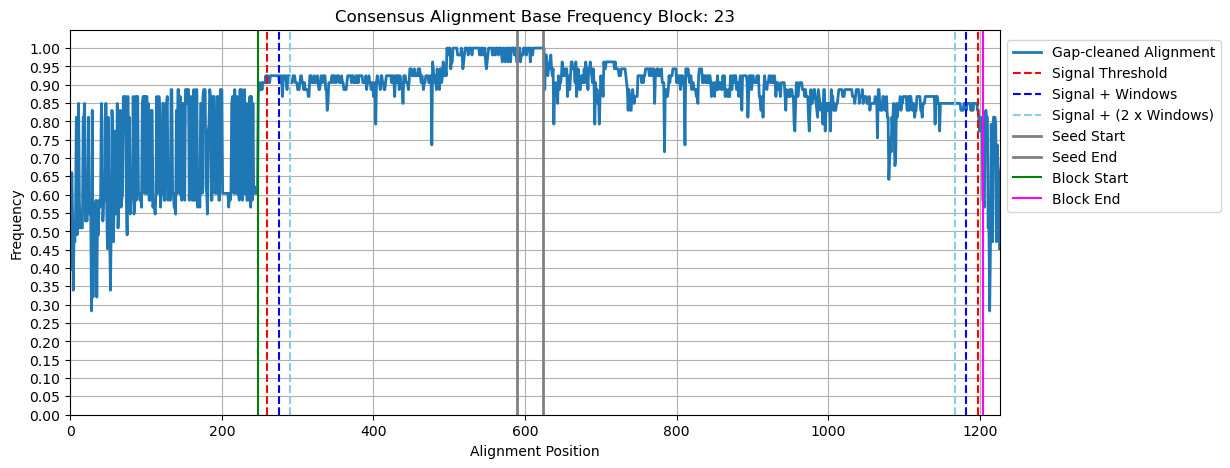

Working on target seed: k:1152_c:40
Working on target seed: k:1217_c:39
Working on target seed: k:842_c:48
Working on target seed: k:940_c:44
Working on target seed: k:1030_c:42
Working on target seed: k:964_c:44
Working on target seed: k:963_c:44
Working on target seed: k:867_c:46
Working on target seed: k:883_c:46
Working on target seed: k:900_c:45
Working on target seed: k:902_c:45
Working on target seed: k:948_c:44
Working on target seed: k:1143_c:40
Working on target seed: k:1140_c:40
Working on target seed: k:1178_c:39
Working on target seed: k:921_c:45
Working on target seed: k:1207_c:39
Working on target seed: k:939_c:44
Working on target seed: k:959_c:44
Working on target seed: k:1059_c:41
Working on target seed: k:877_c:46
Working on target seed: k:930_c:45
Working on target seed: k:890_c:45
Working on target seed: k:913_c:45
Working on target seed: k:911_c:45
Working on target seed: k:863_c:47
Working on target seed: k:941_c:44
Working on target seed: k:918_c:45
Working on t

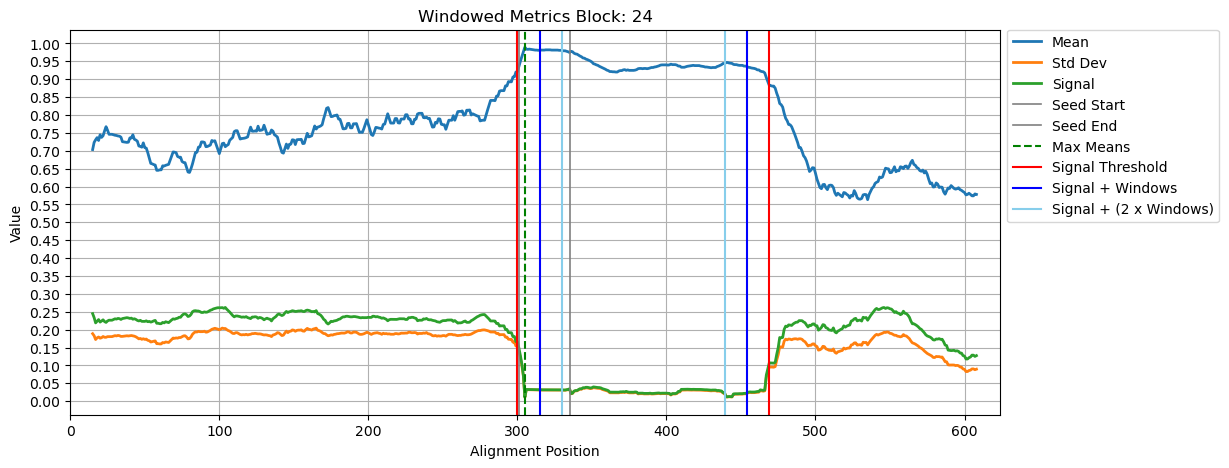

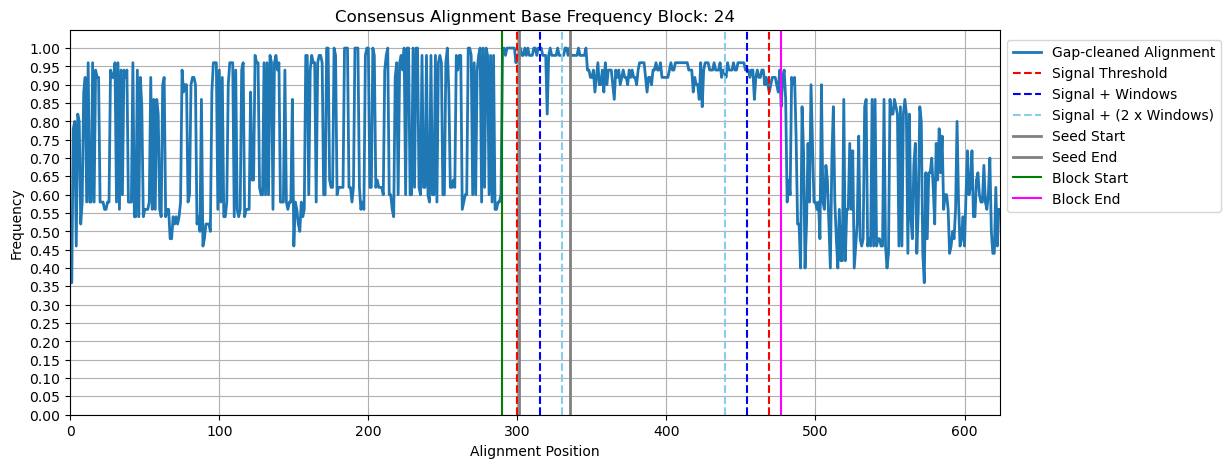

Working on target seed: k:1082_c:41
Working on target seed: k:897_c:45
Working on target seed: k:947_c:44
Working on target seed: k:942_c:44
Working on target seed: k:956_c:44
Working on target seed: k:966_c:44
Working on target seed: k:857_c:47
Working on target seed: k:958_c:44
Working on target seed: k:1033_c:42
Working on target seed: k:1028_c:42
Working on target seed: k:955_c:44
Working on target seed: k:1150_c:40
Working on target seed: k:1158_c:40
Working on target seed: k:1228_c:39
Working on target seed: k:1234_c:39
Working on target seed: k:1222_c:39
Working on target seed: k:1200_c:39
Working on target seed: k:1081_c:41
Working on target seed: k:1091_c:41
Working on target seed: k:1338_c:37
Working on target seed: k:1342_c:37
Working on target seed: k:1347_c:37
Working on target seed: k:1350_c:37
Working on target seed: k:1048_c:42
Working on target seed: k:910_c:45
Working on target seed: k:992_c:43
Working on target seed: k:1051_c:42
Working on target seed: k:1045_c:42
Wo

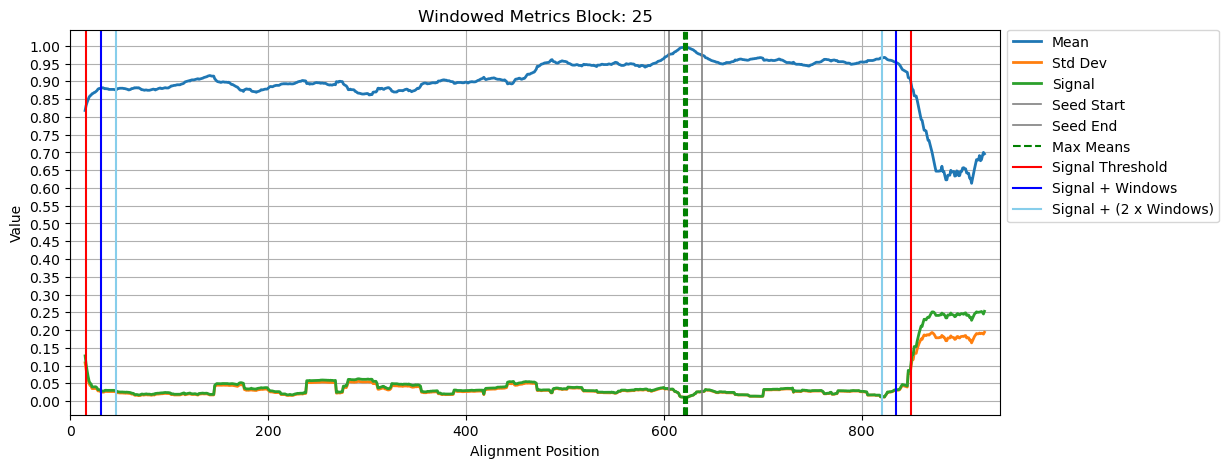

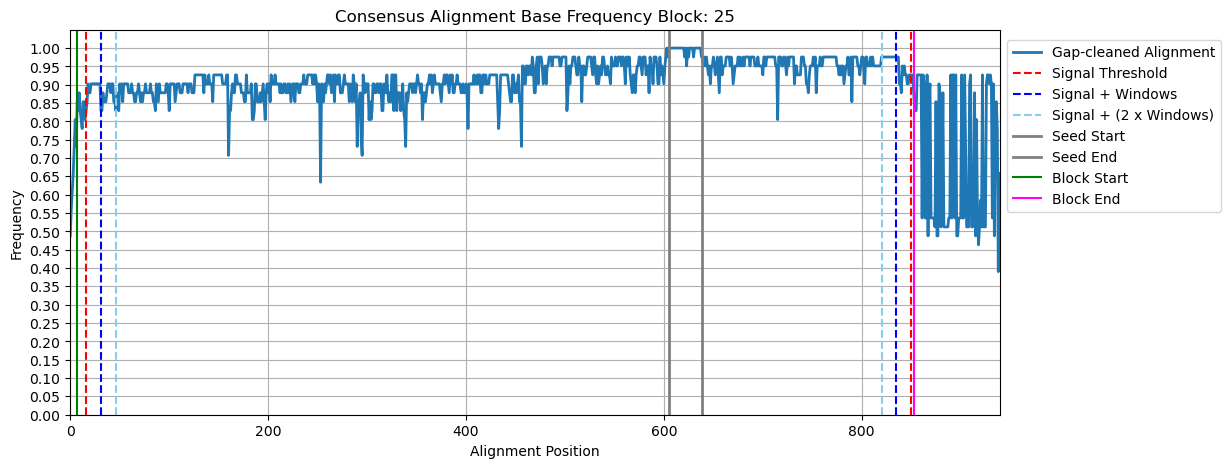

Working on target seed: k:1402_c:36
Working on target seed: k:1395_c:36
Working on target seed: k:1417_c:36
Working on target seed: k:1480_c:35
Working on target seed: k:1467_c:35
Working on target seed: k:1428_c:36
Working on target seed: k:1465_c:35
Working on target seed: k:1339_c:37
Working on target seed: k:1355_c:37
Working on target seed: k:1366_c:37
Working on target seed: k:1411_c:36
Working on target seed: k:1407_c:36
Working on target seed: k:1352_c:37
Working on target seed: k:1415_c:36
Working on target seed: k:1426_c:36
Working on target seed: k:1434_c:36
Working on target seed: k:1451_c:35
Working on target seed: k:1488_c:35
Working on target seed: k:1473_c:35
Working on target seed: k:1455_c:35
Working on target seed: k:1353_c:37
Working on target seed: k:1400_c:36
Working on target seed: k:1363_c:37
Working on target seed: k:1421_c:36
Working on target seed: k:1410_c:36
Working on target seed: k:1466_c:35
Working on target seed: k:1413_c:36
Working on target seed: k:14